-----
# 02 - Unibiomarker Analysis

In [1]:
from pathlib import Path
import seaborn as sns
import pandas as pd

from utils import format_dataframe, add_ratio_columns
from unibiomarker import Unibiomarker
import constants

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Default Plot Style : 
sns.set(style="whitegrid")


## 1. Data Loading & Preparation

In [2]:
# Set path to Data Directory : 
DIR_DATA = Path.cwd() / "data"

# Check existence to training/test files : 
print(fr"Data Directory    : {str(DIR_DATA)}")
print(fr"Train Data exists : {(DIR_DATA / 'cercare_training_data.xlsx').exists()}")
print(fr"Test Data exists  : {(DIR_DATA / 'cercare_test_data.xlsx').exists()}")


Data Directory    : C:\Users\maichi\work\my_projects\CercareStatAnalysis\data
Train Data exists : True
Test Data exists  : True


In [3]:
# Load Cercare Training / Test Excel spreadsheets :
df_data = pd.read_excel(DIR_DATA / "cercare_training_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)
df_test = pd.read_excel(DIR_DATA / "cercare_test_data.xlsx").rename(columns=constants.DICT_RENAMING_MAPPING)

# Format dataframes : 
df_data = format_dataframe(df=df_data)
df_test = format_dataframe(df=df_test)

# Add the ratio columns : 
add_ratio_columns(df_data)
add_ratio_columns(df_test)

print("Data Loaded and formatted Successfully ! ")


Data Loaded and formatted Successfully ! 


##  2. 🔧  Configuration 

In [4]:
BIOMARKER = "CTH MAX"  # Choose from :  ADC, CBV_corr, CBV_noncorr, DELAY, CTH, CTH MAX, OEF, rLEAKAGE, rCMRO2, COV

In [5]:
# Unibiomarker object Initialization : 
ub = Unibiomarker(name=BIOMARKER, data = df_data, test_data=df_test)
print(ub)


Biomarker object
- Parameters: CTH MAX_lésion, CTH MAX_control, CTH MAX_ratio
- Training samples: 182
- Test samples: 23



## 3. Descriptive Analysis

### 3.1 Check for missing values

Fully usable rows in train: 179/182 (98.4%)
Fully usable rows in test:  23/23 (100.0%)


,Train Missing %,Test Missing %
CTH MAX_lésion,1.6,0.0
CTH MAX_control,0.5,0.0
CTH MAX_ratio,1.6,0.0


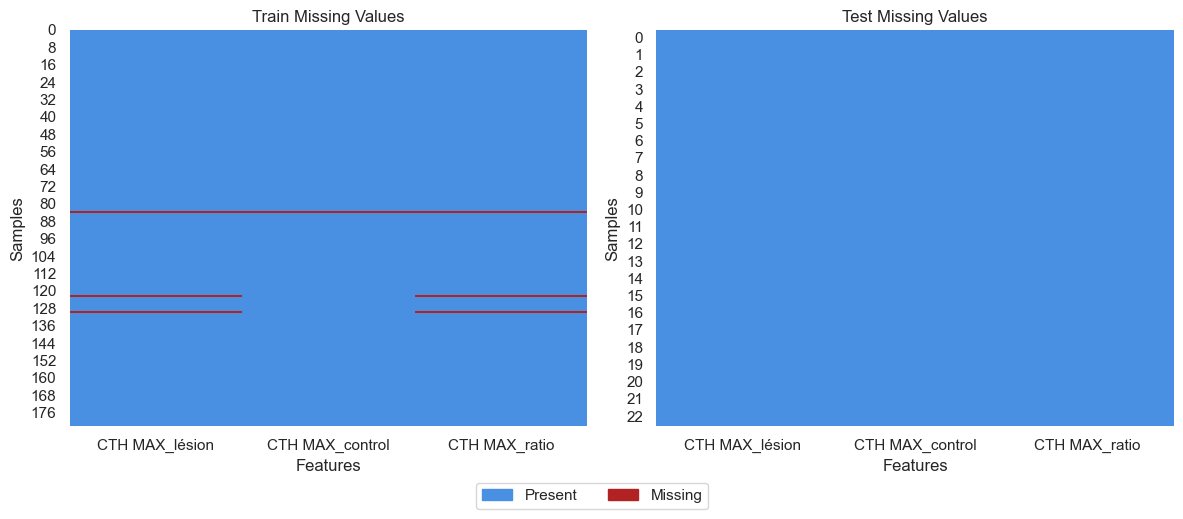

In [6]:
ub.check_missing_data()


### 3.2 Describe & Visualize key features

In [7]:
ub.describe_features(features=[ub.path, ub.control])


Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CTH MAX_lésion,179.0,5.188380,4.485028,0.10,1.945,3.75,7.555,24.12
CTH MAX_control,181.0,5.665967,3.965074,0.37,2.960,4.53,7.470,23.01



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CTH MAX_lésion,0,108.0,2.640833,1.636433,0.10,1.3900,2.32,3.4625,10.00
2,CTH MAX_lésion,1,71.0,9.063521,4.670442,2.62,5.6000,8.71,10.5500,24.12
1,CTH MAX_control,0,110.0,7.087091,4.245708,1.49,3.7575,6.36,9.0450,23.01
3,CTH MAX_control,1,71.0,3.464225,2.065876,0.37,2.1000,3.28,4.3600,14.58


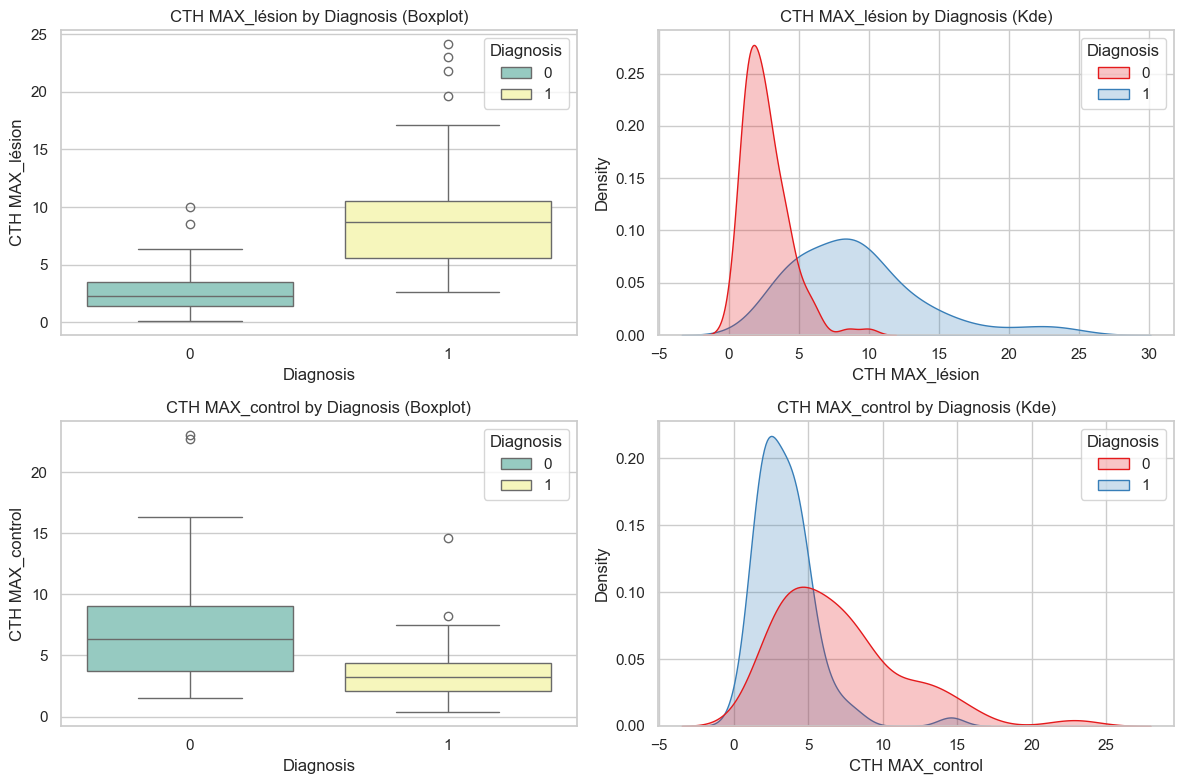

In [8]:
ub.plot_feature_distributions(features=[ub.path, ub.control], plots=["boxplot", "kde"])


### 3.3 Ratio Analysis

The goal of this section is to check correlation between the path variable and the control variable

The ratio is defined as:  
**`Ratio = Path / Control`**

To assess whether this ratio provides *new, meaningful information*, we first examine the correlation between `Path` and `Control` values:

---

#### 🔍 What we check

1. **Pearson correlation** (linear relationship)  
   Measures the strength of a **linear** association between `Path` and `Control`.

   $$
   r = \frac{\text{Cov}(X, Y)}{\sigma_X \cdot \sigma_Y}
   $$

2. **Spearman correlation** (monotonic relationship)  
   Applies the Pearson formula to the **ranked values** rather than raw values.

   $$
   \rho = \frac{\text{Cov}(\text{Rank}(X), \text{Rank}(Y))}{\sigma_{\text{Rank}(X)} \cdot \sigma_{\text{Rank}(Y)}}
   $$

   This makes Spearman suitable for detecting **monotonic relationships** that are not necessarily linear.

3. **Statistical significance** (p-values)  
   For both Pearson and Spearman, a **p-value** tests the null hypothesis that the correlation is zero (i.e., no association exists):

   - A **low p-value** (typically < 0.05) indicates that the correlation is **statistically significant**  
   - A **high p-value** means there is **insufficient evidence** to conclude that a statistically significant correlation exists
     

In [9]:
ub.describe_features(features=[ub.ratio])

Overall Descriptive Statistics : 


,count,mean,std,min,25%,50%,75%,max
CTH MAX_ratio,179.0,1.362994,1.385922,0.067114,0.365582,0.489387,2.311616,7.351351



Descriptive Statistics by 'Diagnosis' Class:


,Feature,Class,count,mean,std,min,25%,50%,75%,max
0,CTH MAX_ratio,0,108.0,0.389373,0.109550,0.067114,0.316516,0.387845,0.471808,0.676213
1,CTH MAX_ratio,1,71.0,2.843995,1.085676,1.463415,2.101866,2.476395,3.078815,7.351351


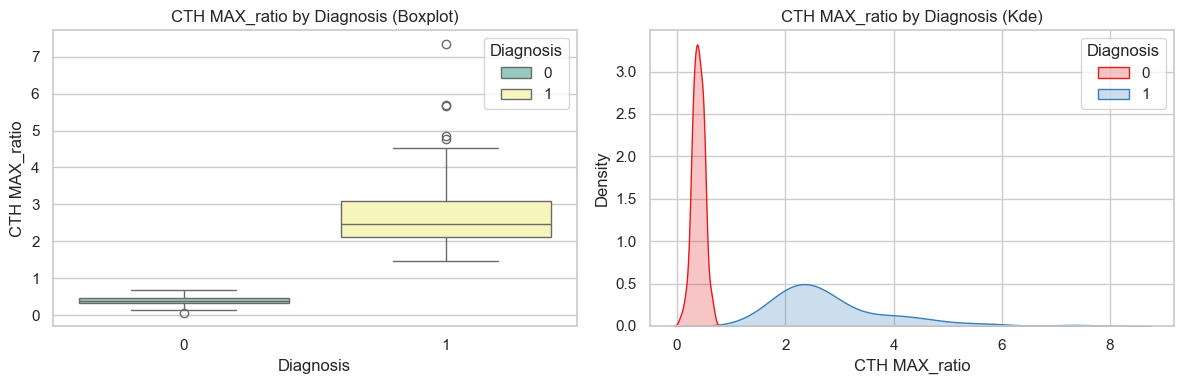

In [10]:
ub.plot_feature_distributions(features=[ub.ratio], plots=["boxplot", "kde"])

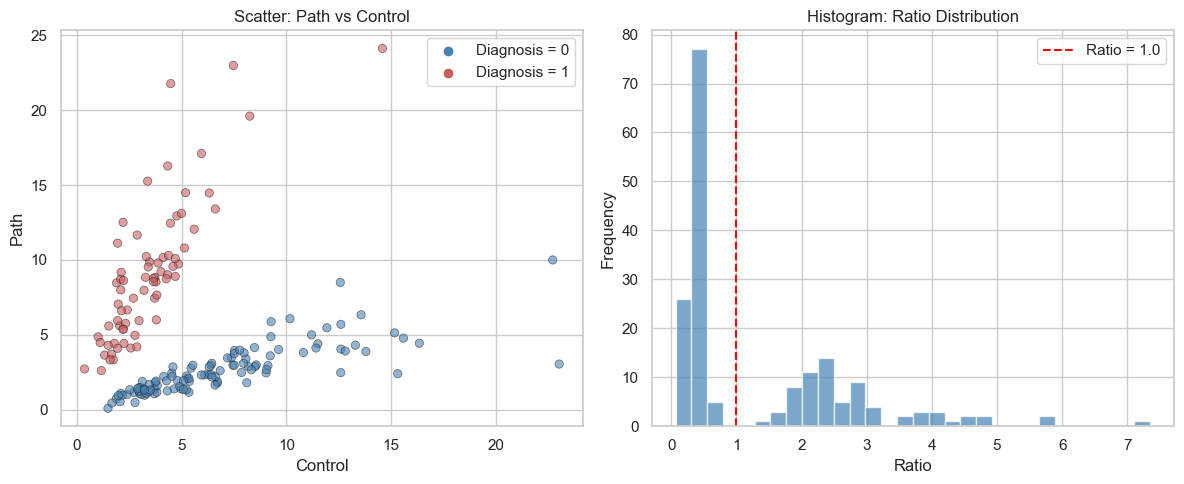

In [11]:
ub.plot_diagnostic_scatter_and_ratio()

In [12]:
ub.evaluate_path_control_correlation()

🔍 Analyzing Biomarker: CTH MAX
------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 1: Correlation Analysis between Path and Control 
------------------------------------------------------------------------------------------------------------------------------------------------------
- Pearson  correlation: r = 0.056, p = 0.4576
- Spearman correlation: r = 0.085, p = 0.2553

------------------------------------------------------------------------------------------------------------------------------------------------------
--- Step 2: Interpretation Guidance 
------------------------------------------------------------------------------------------------------------------------------------------------------
Neither Pearson nor Spearman correlation is statistically significant ! 
No clear association between Path and Control ! 
The ratio is a worthwhile feature to explore ! 


## 4.  Discriminative Power of the Biomarker


In this section, we assess whether features like `path` and `ratio` can **discriminate between diagnostic groups**, such as Tumor Recurrence and Radiation Necrosis.

---

#### Step 1 – Normality Check

We start with **Q–Q plots** to visually evaluate whether the distribution of the feature within each group appears **approximately normal**. This helps decide whether we can meaningfully apply a parametric test that models the **data distribution**.

---
#### Step 2 – Choosing the Right Statistical Test

- If the feature appears **normally distributed** in each group, we apply a **Welch’s t-test**.
  - This test assumes the data follows a normal distribution and compares the **means** between groups.
  - Using a parametric test like this is valuable because it lets us **model the data with a known distribution**

- If the feature **does not appear normally distributed**, we instead use the **Mann–Whitney U test**.
  - This is a **non-parametric** test that compares whether values in one group tend to be higher or lower than in the other.
  - It doesn’t assume any specific distribution and works on **ranked data** rather than actual values.
  - But it doesn’t let us **model or describe the underlying distribution** of the data 

---

#### Step 3 – Interpreting the Results

If either test reports a **statistically significant difference** (typically p < 0.05), it suggests that the feature behaves differently between groups — a necessary condition for it to be useful as a biomarker

### 4.1. Distribution Differences: Path Feature

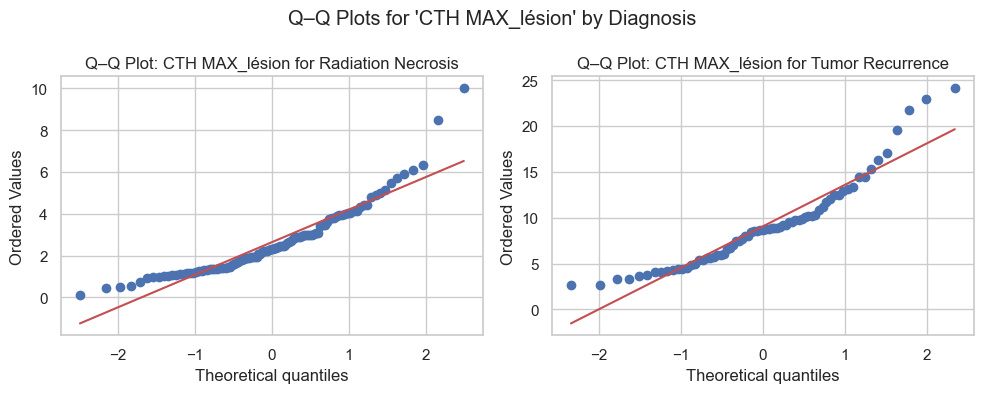

In [13]:
ub.plot_qq_by_group(feature=ub.path)

In [14]:
ub.test_group_difference(feature=ub.path)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -11.1464, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 387.5000, p = 0.0000   → ✅ Significant difference



🔎 [ROC-Based Classification] Feature: 'CTH MAX_lésion'
--------------------------------------------------------------------------------
AUC (Train) : 0.949  (95% CI: 0.921 – 0.978)
AUC (Test)  : 0.732  (95% CI: 0.425 – 1.000)

 Optimal threshold (Youden’s J): 4.100
 Classification Rule          : Class = 1 if CTH MAX_lésion ≥ 4.100

▶ TRAIN SET METRICS AT THRESHOLD: 4.100
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      87.7
Recall (Sensitivity) |      91.5
Specificity          |      85.2
Precision            |      80.2
F1 Score             |      85.5

▶ TEST SET METRICS AT THRESHOLD: 4.100
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      47.8
Recall (Sensitivity) |      71.4
Specificity          |      37.5
Precision            |      33.3
F1 Score       

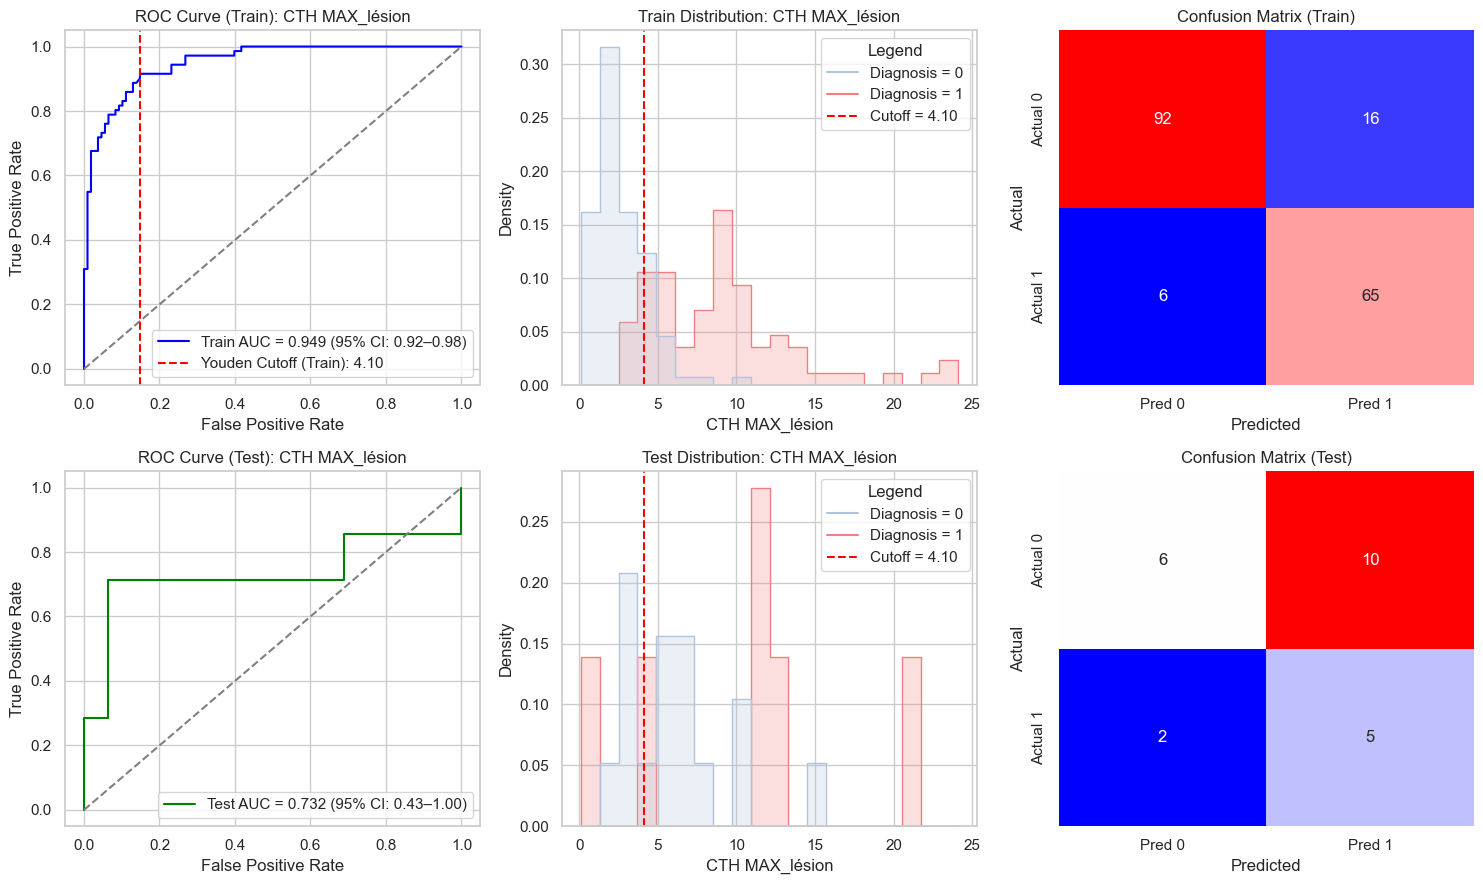

In [15]:
ub.evaluate_feature_predictive_power(feature=ub.path, target_bin_count=20)

### 4.2. Distribution Differences: Path Feature

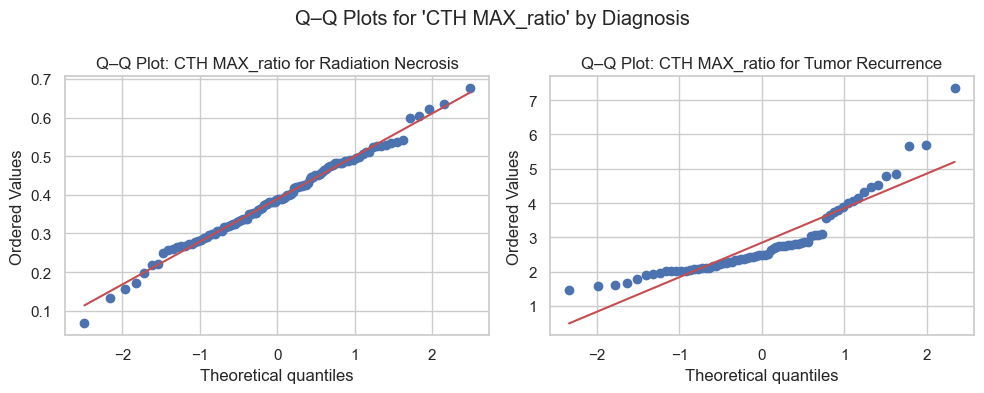

In [16]:
ub.plot_qq_by_group(feature=ub.ratio)

In [17]:
ub.test_group_difference(feature=ub.ratio)

Group Comparison Results:
----------------------------------------------------------------------------------------------------
Welch’s t-test       → statistic = -18.9874, p = 0.0000   → ✅ Significant difference
Mann–Whitney U test  → statistic = 0.0000, p = 0.0000   → ✅ Significant difference


Covariance of AUC is 0.0; defaulting to a small delta for CI computation.

🔎 [ROC-Based Classification] Feature: 'CTH MAX_ratio'
--------------------------------------------------------------------------------
AUC (Train) : 1.000  (95% CI: 1.000 – 1.000)
AUC (Test)  : 0.652  (95% CI: 0.356 – 0.948)

 Optimal threshold (Youden’s J): 1.463
 Classification Rule          : Class = 1 if CTH MAX_ratio ≥ 1.463

▶ TRAIN SET METRICS AT THRESHOLD: 1.463
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ TEST SET METRICS AT THRESHOLD: 1.463
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      43.5
Recall (Sensitivity) |      85.7
Specifici

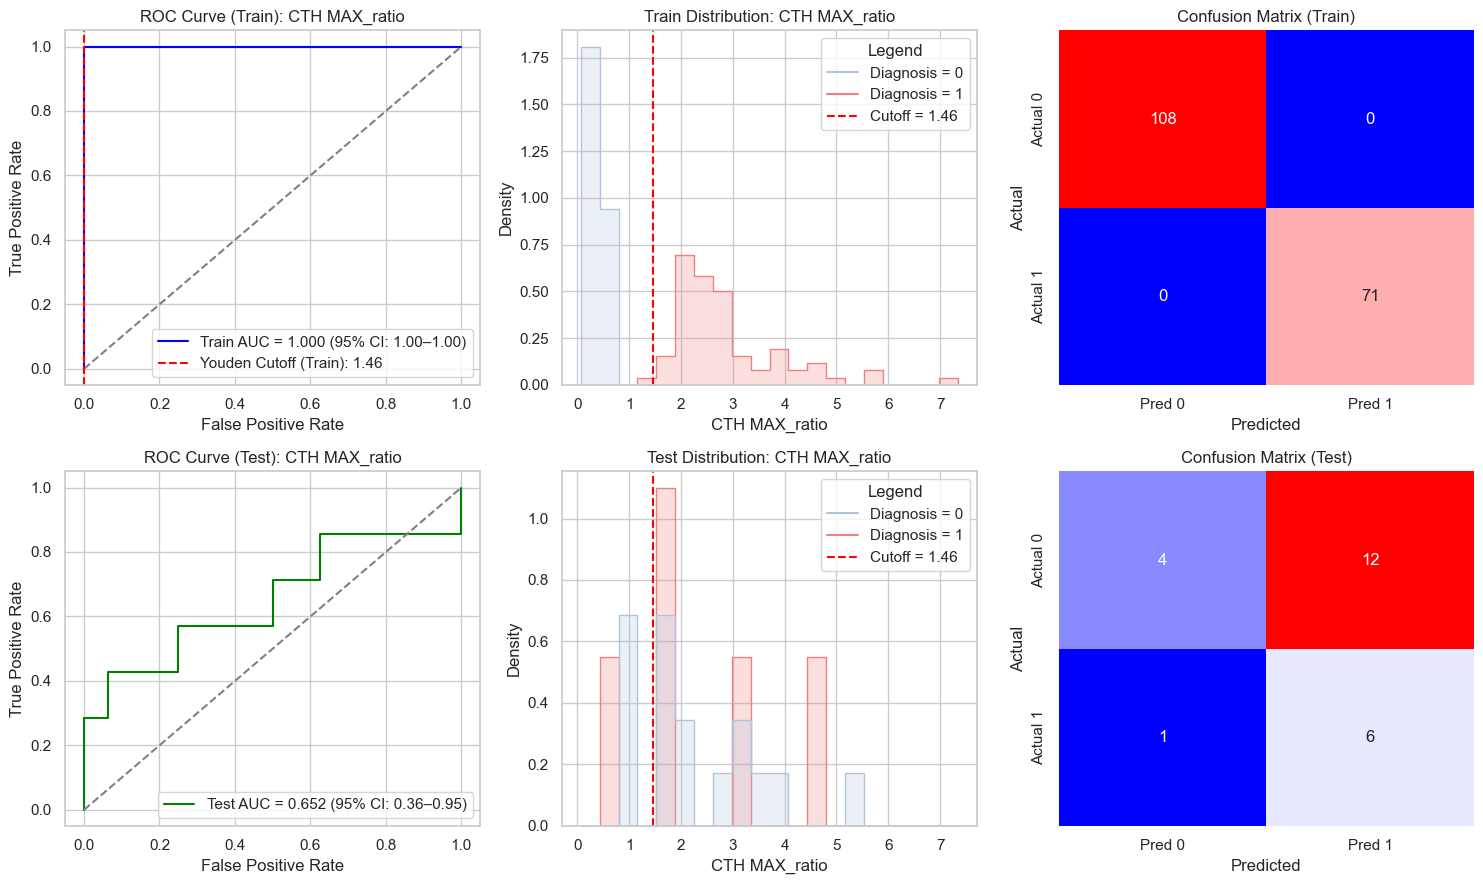

In [18]:
ub.evaluate_feature_predictive_power(feature=ub.ratio, target_bin_count=20)

## 5.  Logistic Regression Modelling

### 5.1 Univariate Logistic Regression 


Logistic Regression Summary for Feature: CTH MAX_lésion
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 0.6755
Odds Ratio           : 1.9651
Youden's J Threshold : 0.3219
----------------------------------------------------------------------------------------------------

▶ [CTH MAX_LÉSION] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      87.7
Recall (Sensitivity) |      78.9
Specificity          |      93.5
Precision            |      88.9
F1 Score             |      83.6

▶ [CTH MAX_LÉSION] TRAIN @ YOUDEN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |      87.7
Recall (Sensitivity) |      91.5
Specificity          |      85.2
Precision            |      80.2
F1 Score       

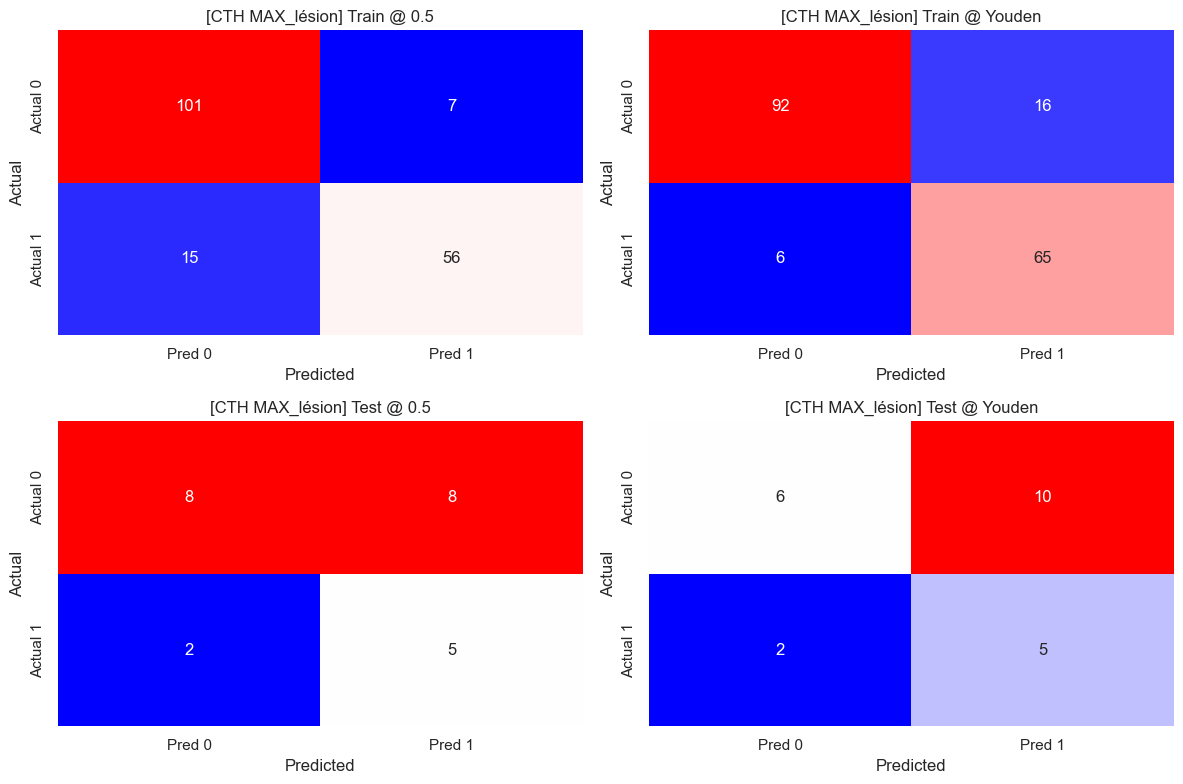

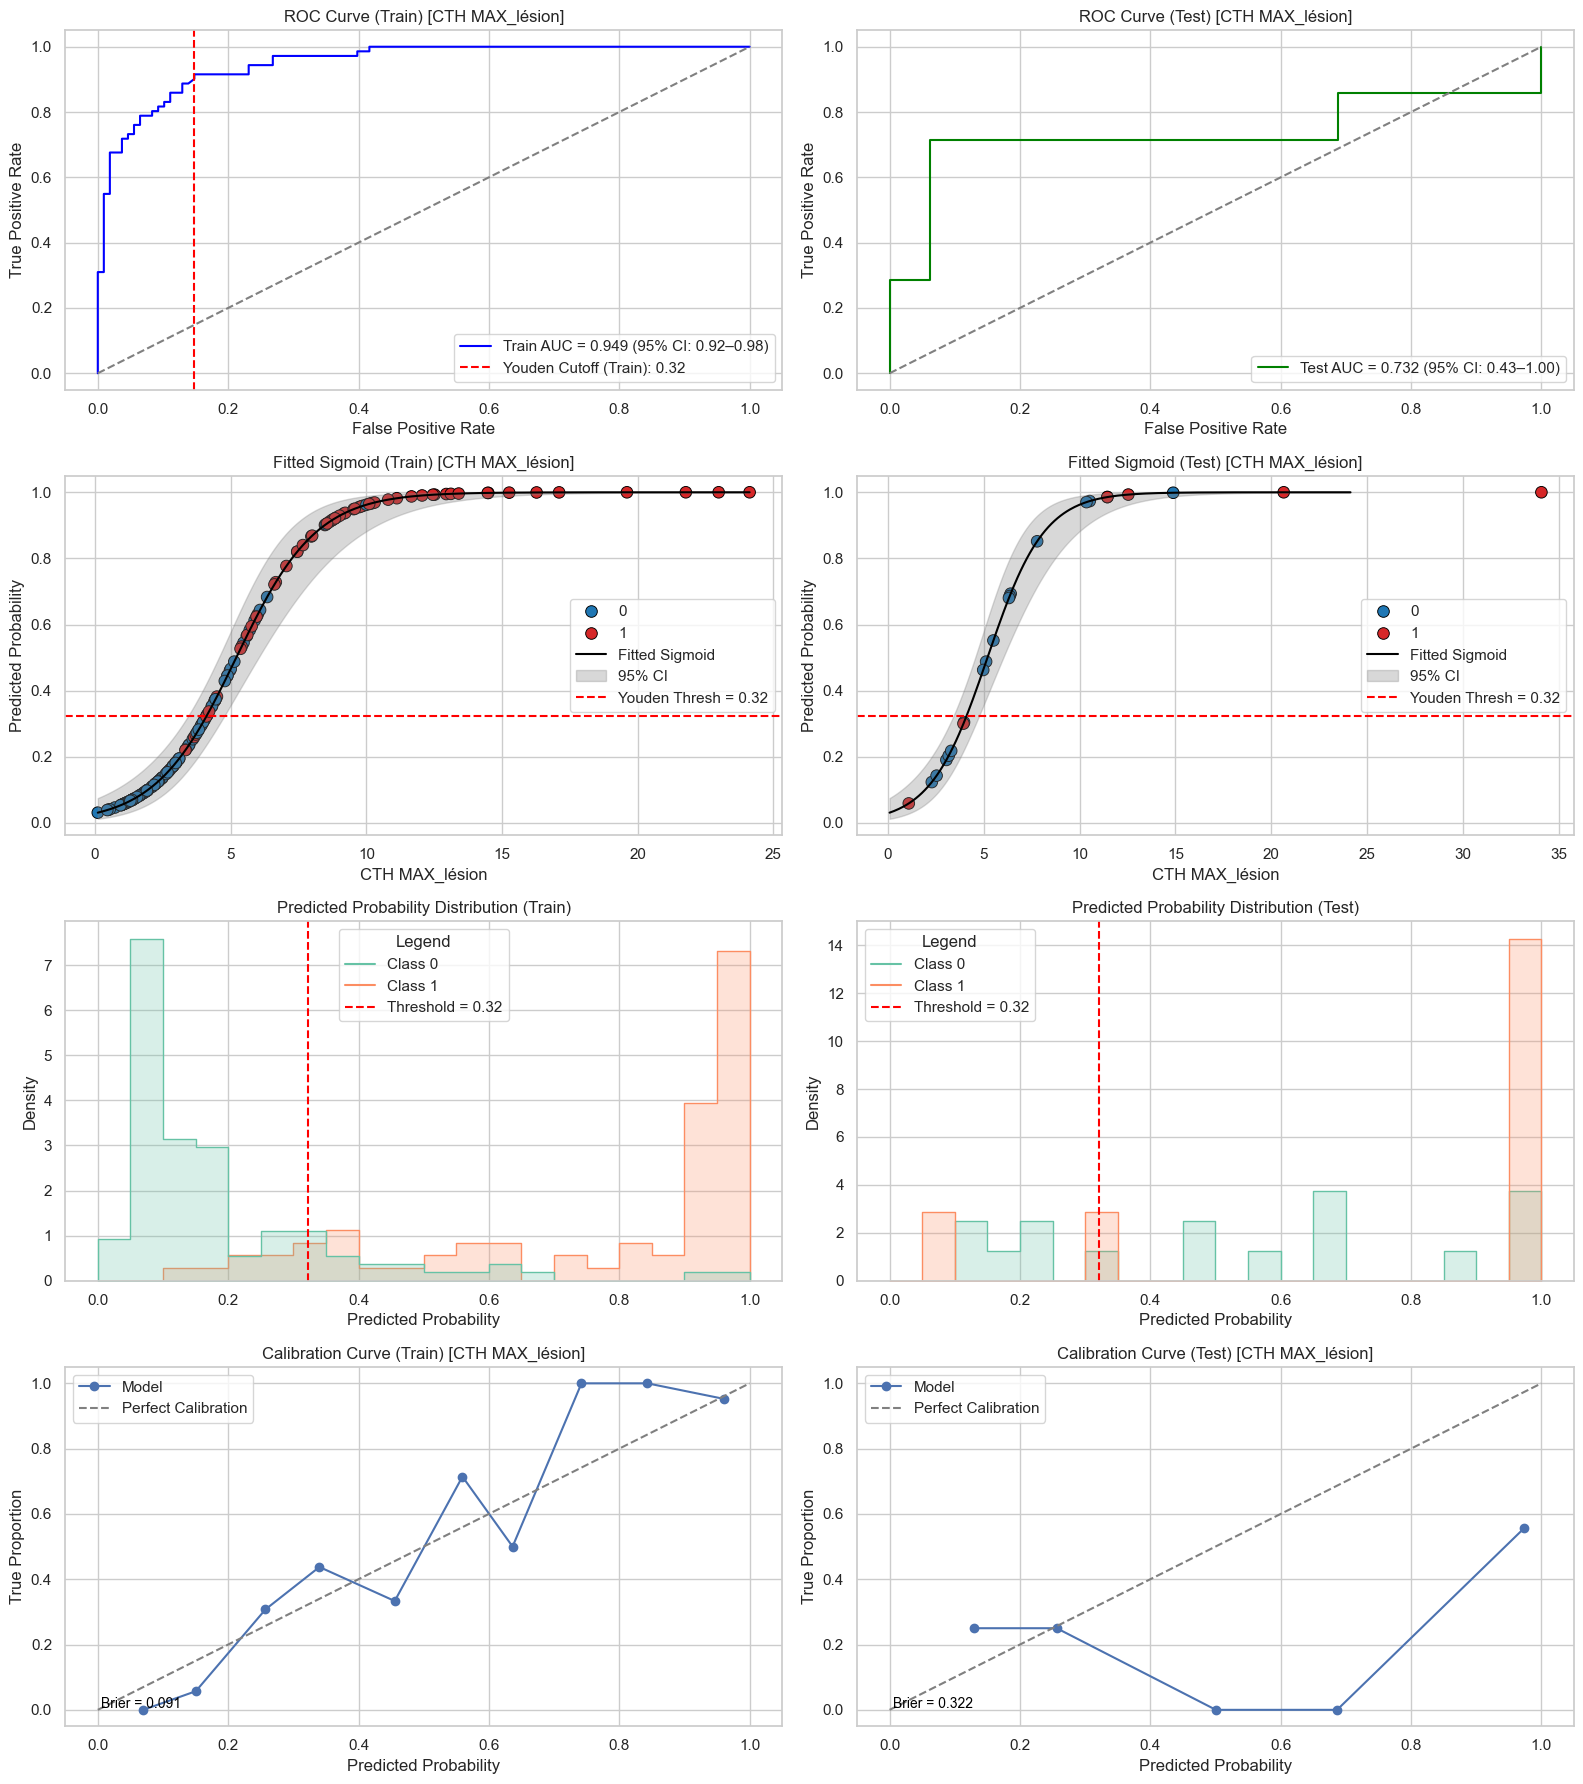

In [19]:
ub.evaluate_logistic_univariate_model(feature=ub.path, target_bin_count=20)

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.

Logistic Regression Summary for Feature: CTH MAX_ratio
----------------------------------------------------------------------------------------------------
Log-Odds Coefficient : 3.1312
Odds Ratio           : 22.9022
Youden's J Threshold : 0.6586
----------------------------------------------------------------------------------------------------

▶ [CTH MAX_RATIO] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [CTH MAX_RATIO] TRAIN @ YOUDEN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specifici

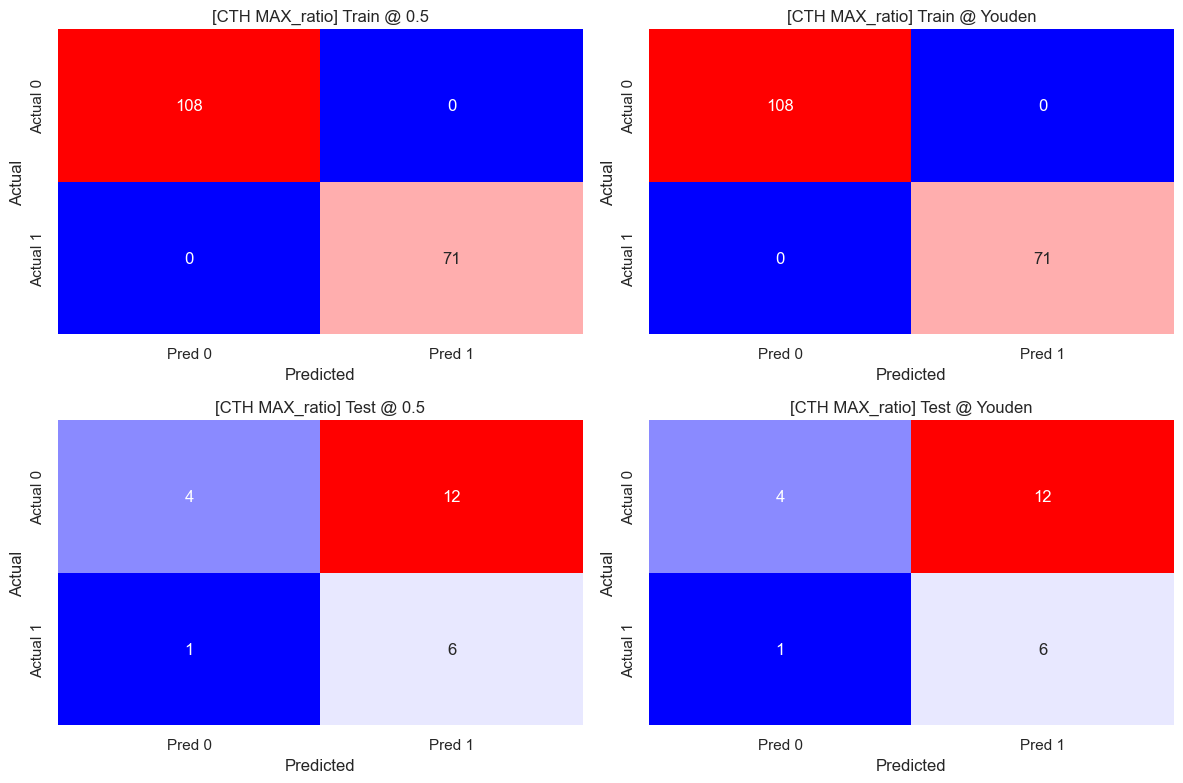

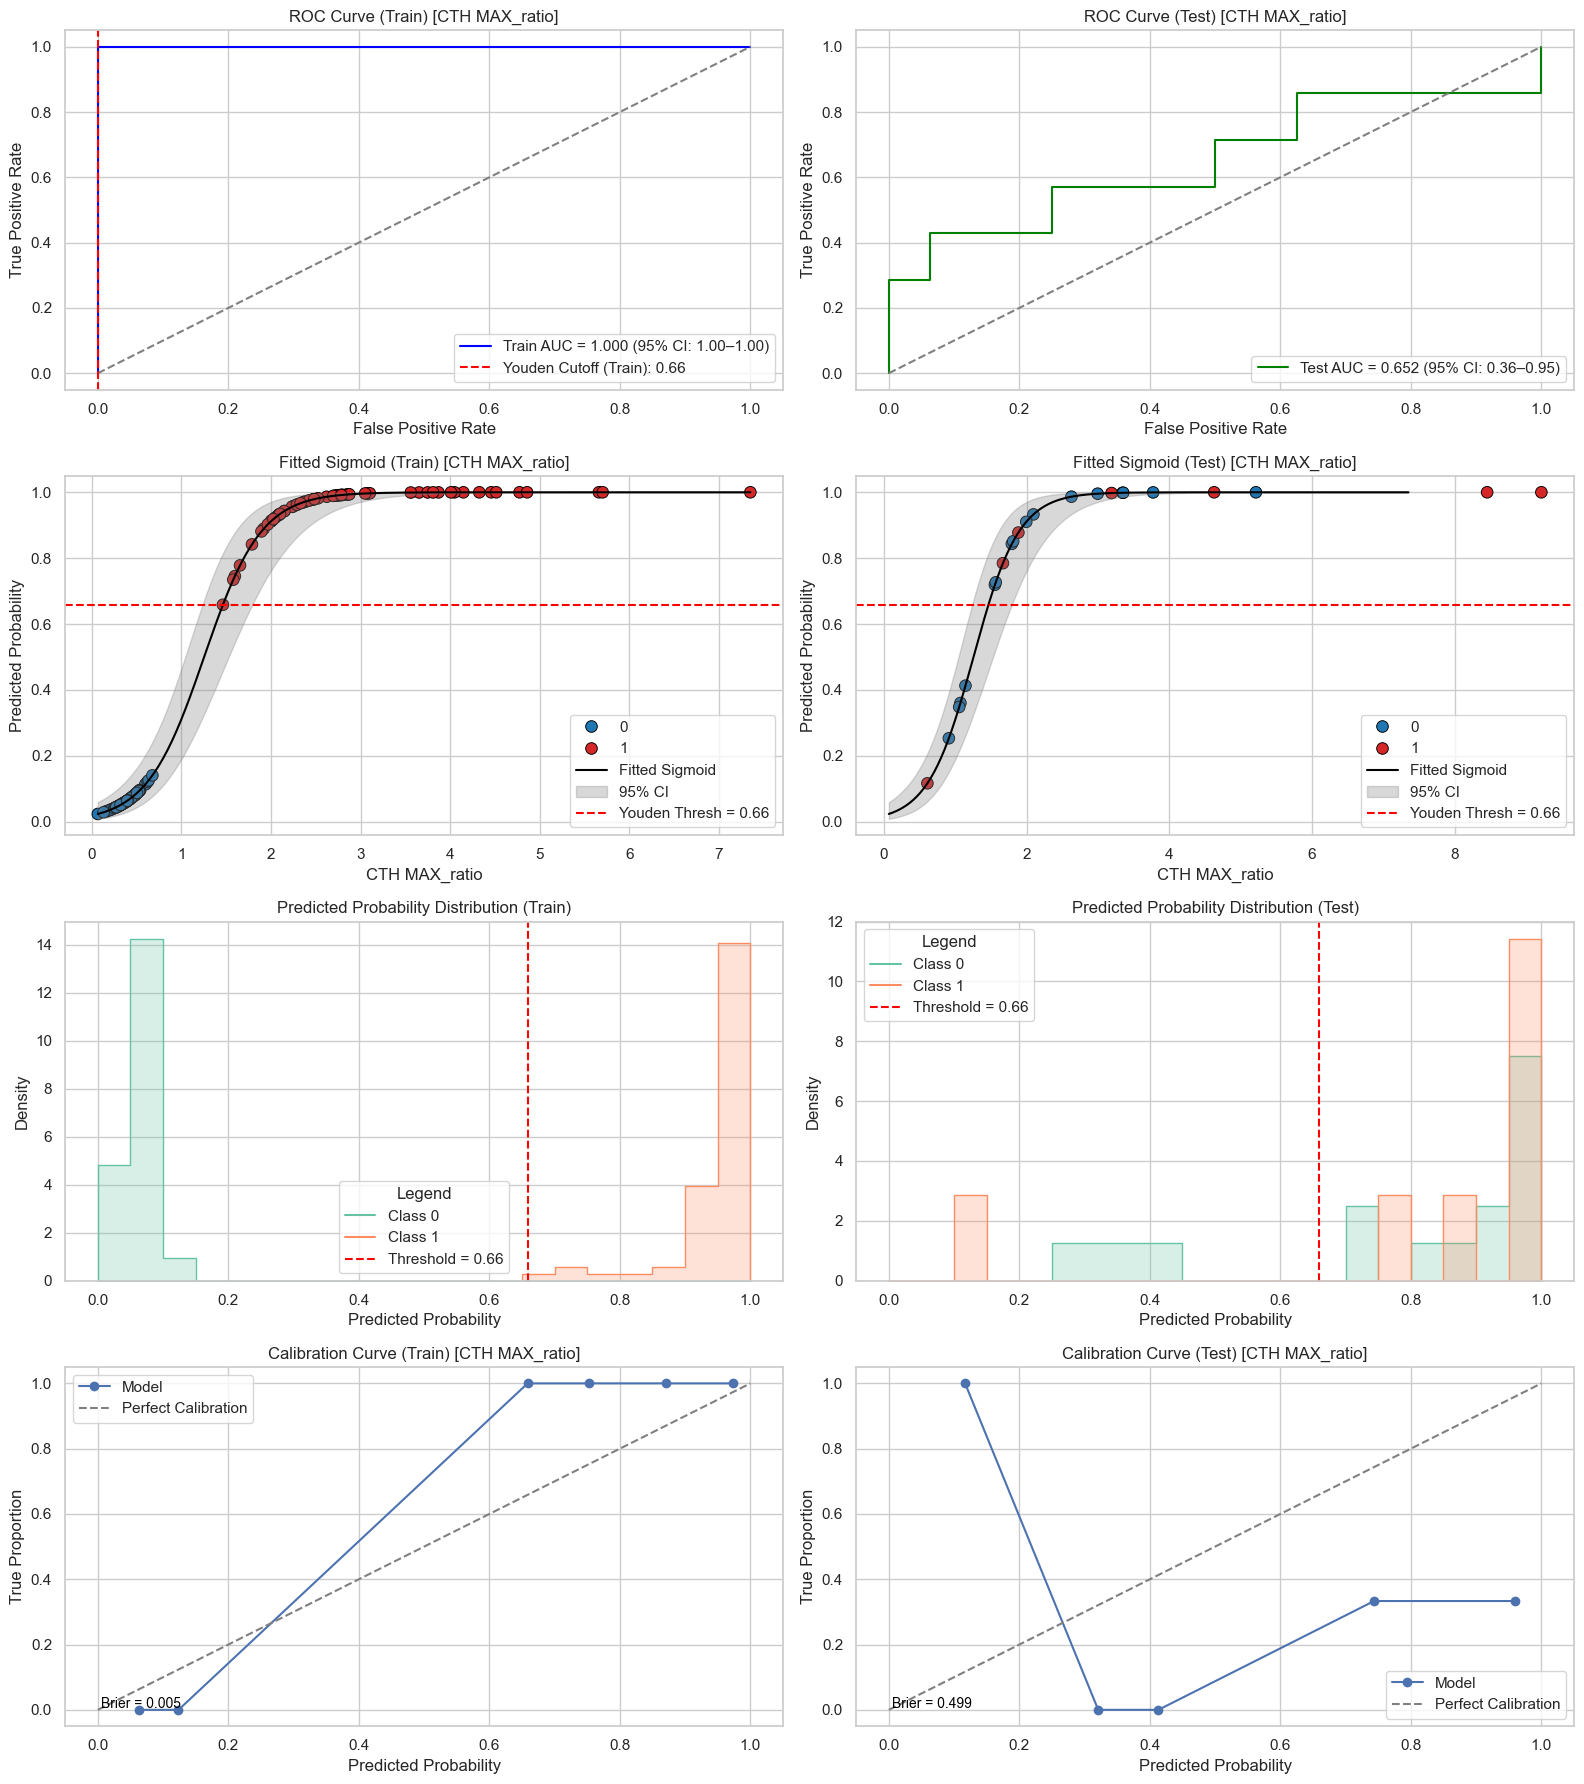

In [20]:
ub.evaluate_logistic_univariate_model(feature=ub.ratio,  target_bin_count=20)

### 5.2 Bivariate Logistic Regression 

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
BIVARIATE LOGISTIC REGRESSION: CTH MAX_lésion + CTH MAX_control
----------------------------------------------------------------------------------------------------
AUC (Train): 1.000 (95% CI: 1.000 – 1.000)
AUC (Test) : 0.714 (95% CI: 0.420 – 1.000)
Optimal Threshold (Youden’s J): 0.597

▶ [CTH MAX_LÉSION + CTH MAX_CONTROL] TRAIN @ 0.5
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [CTH MAX_LÉSION + CTH MAX_CONTROL] TRAIN @ YOUDEN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.

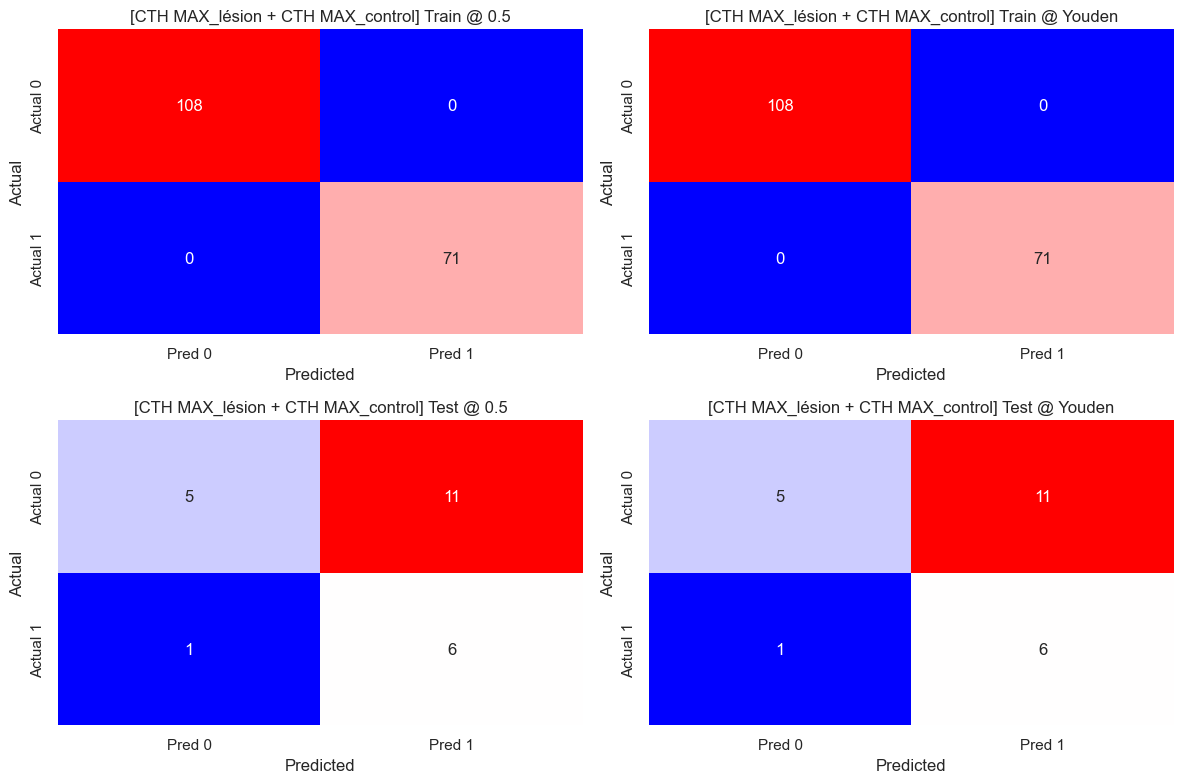

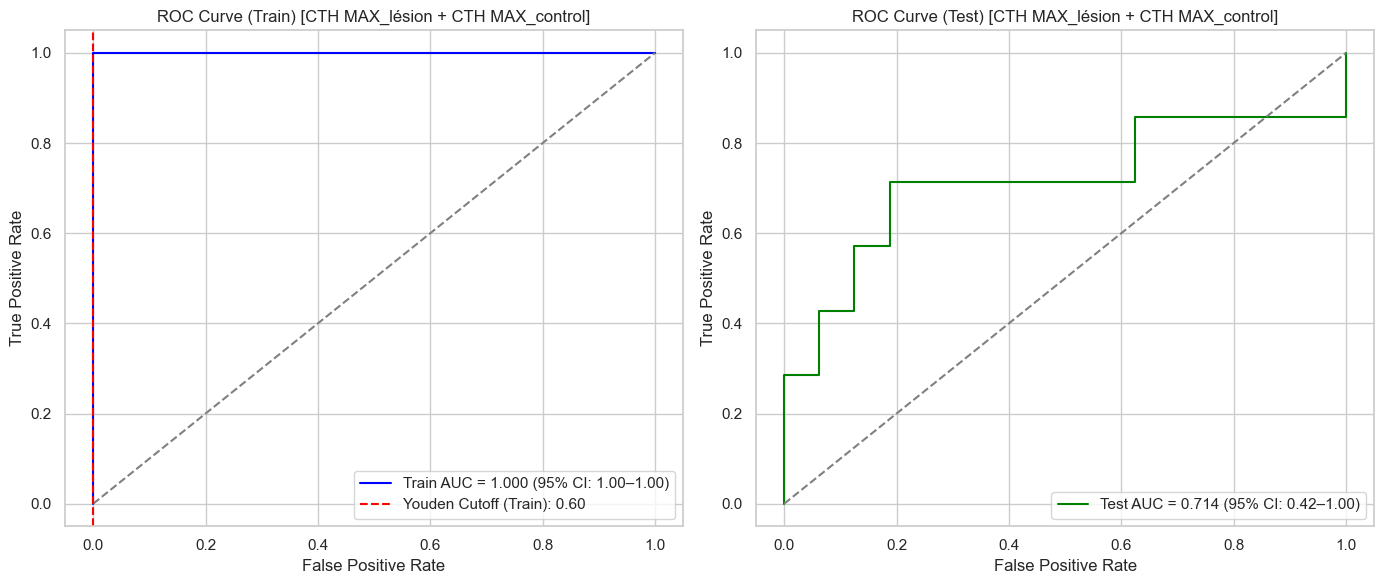

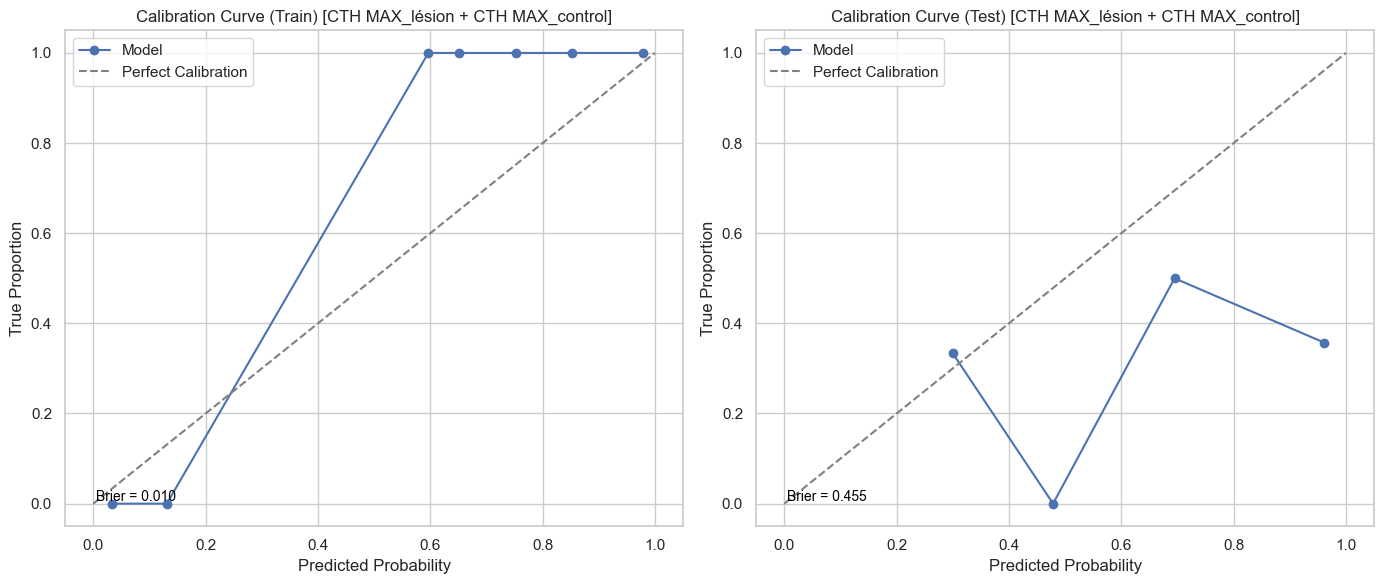

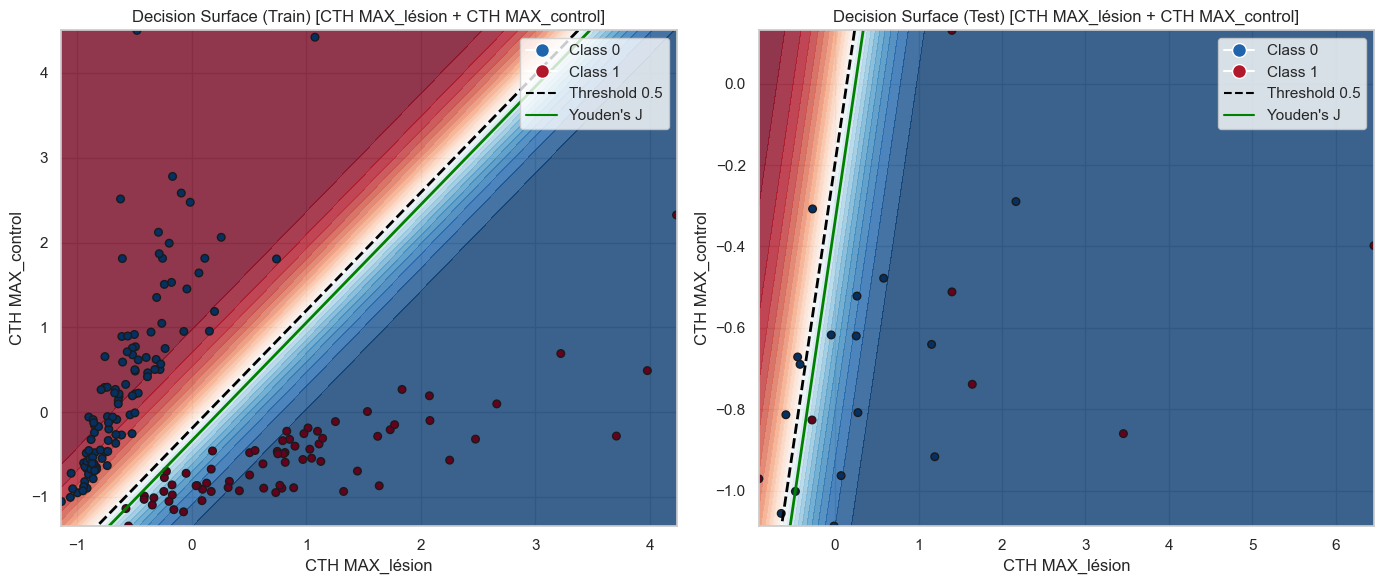

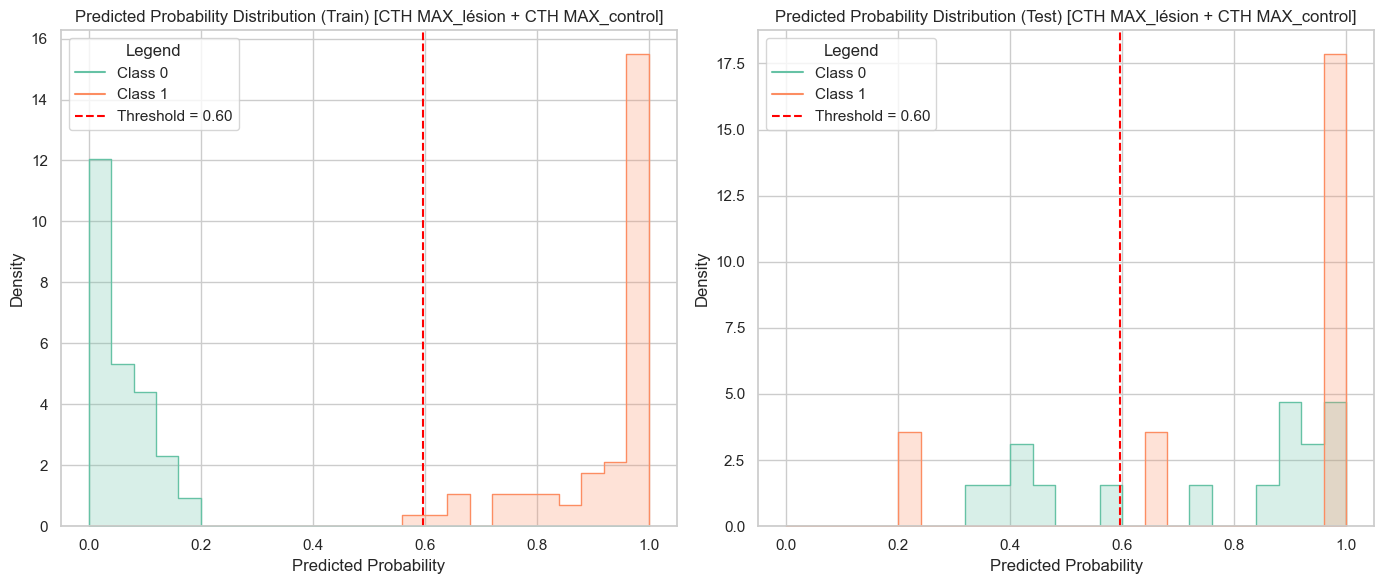

In [21]:
ub.evaluate_logistic_bivariate_model(target_bin_count=25)

## 5.  SVM Modelling

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
SVM (LINEAR) BIVARIATE: CTH MAX_lésion + CTH MAX_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Margin] Test  AUC : 0.714 (95% CI: 0.420 – 1.000)
Optimal Margin Cutoff (Youden): 0.534
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Proba]  Test  AUC : 0.714 (95% CI: 0.420 – 1.000)
Optimal Proba  Cutoff (Youden): 0.703

▶ [CTH MAX_LÉSION + CTH MAX_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            | 

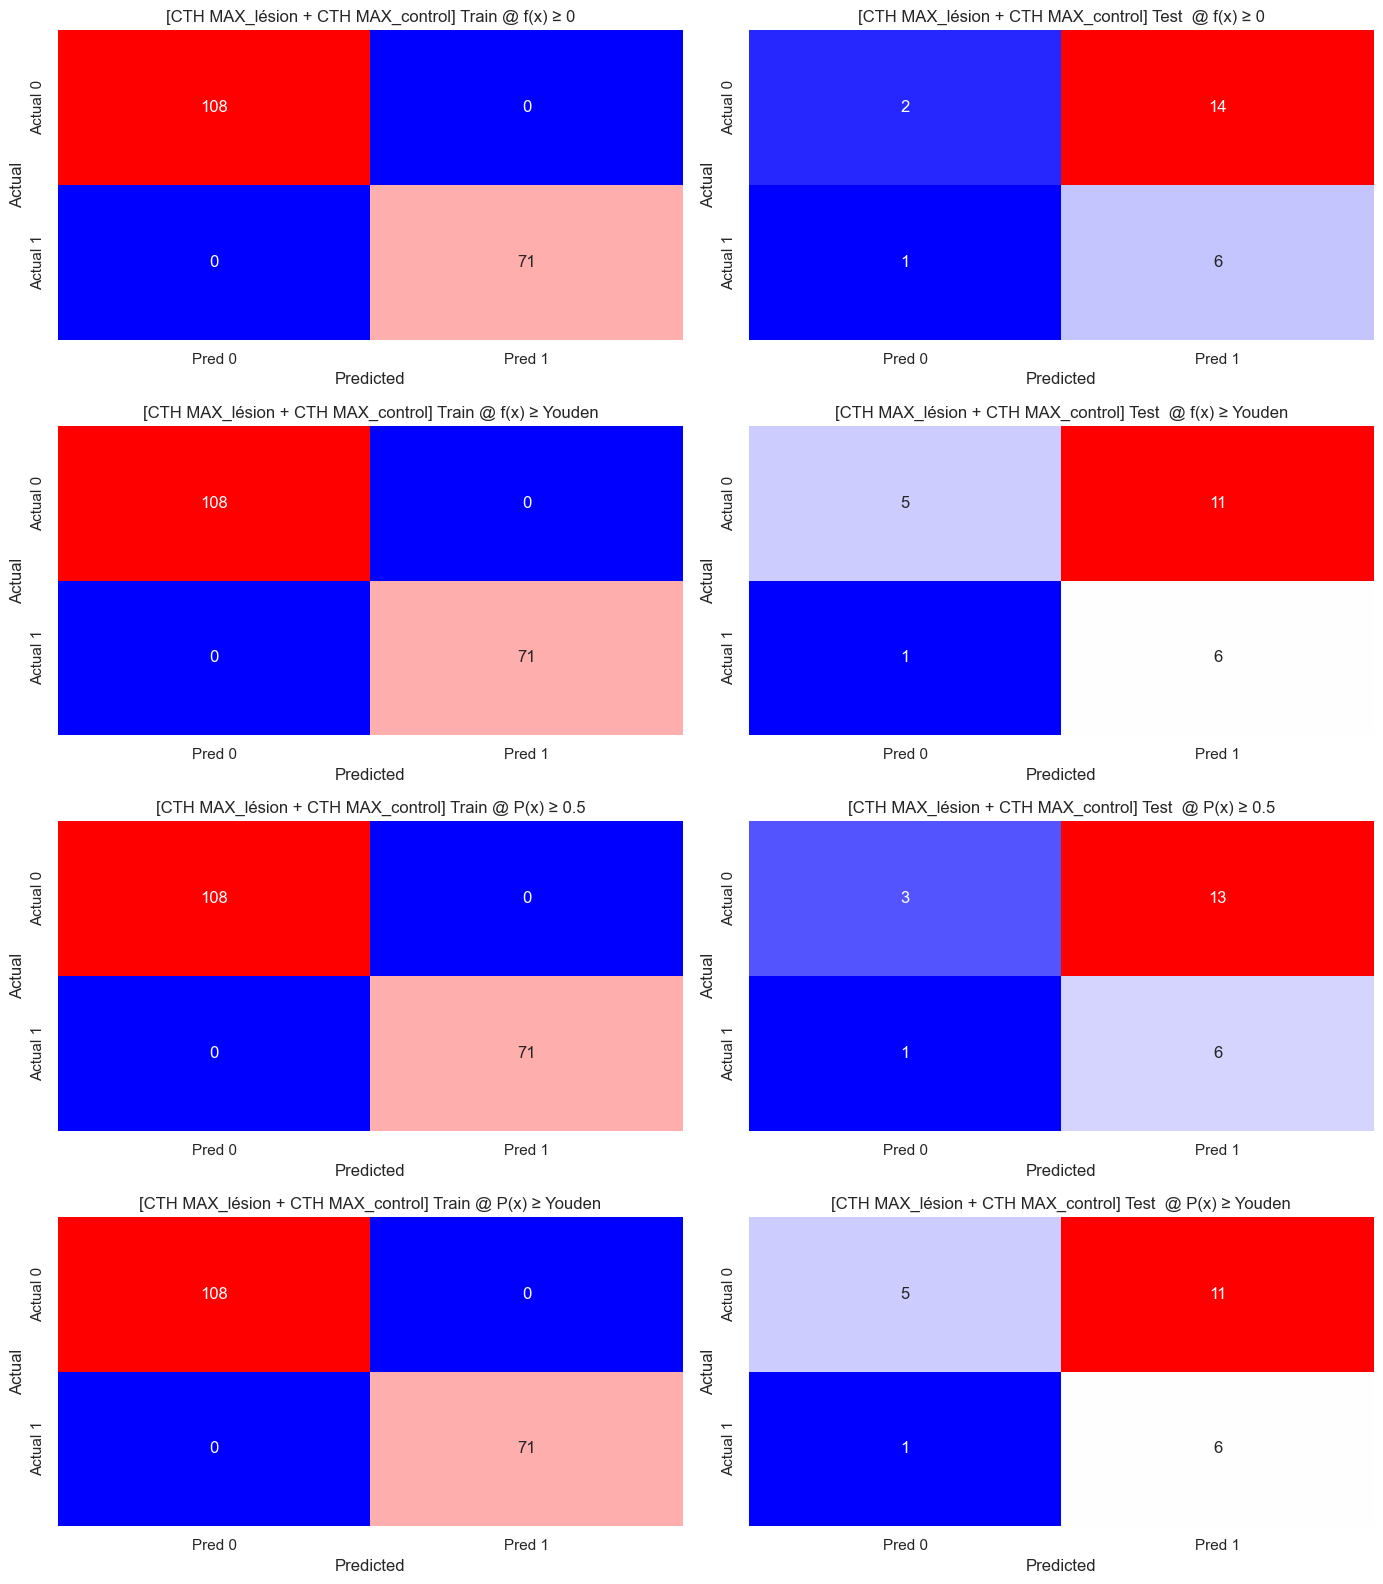

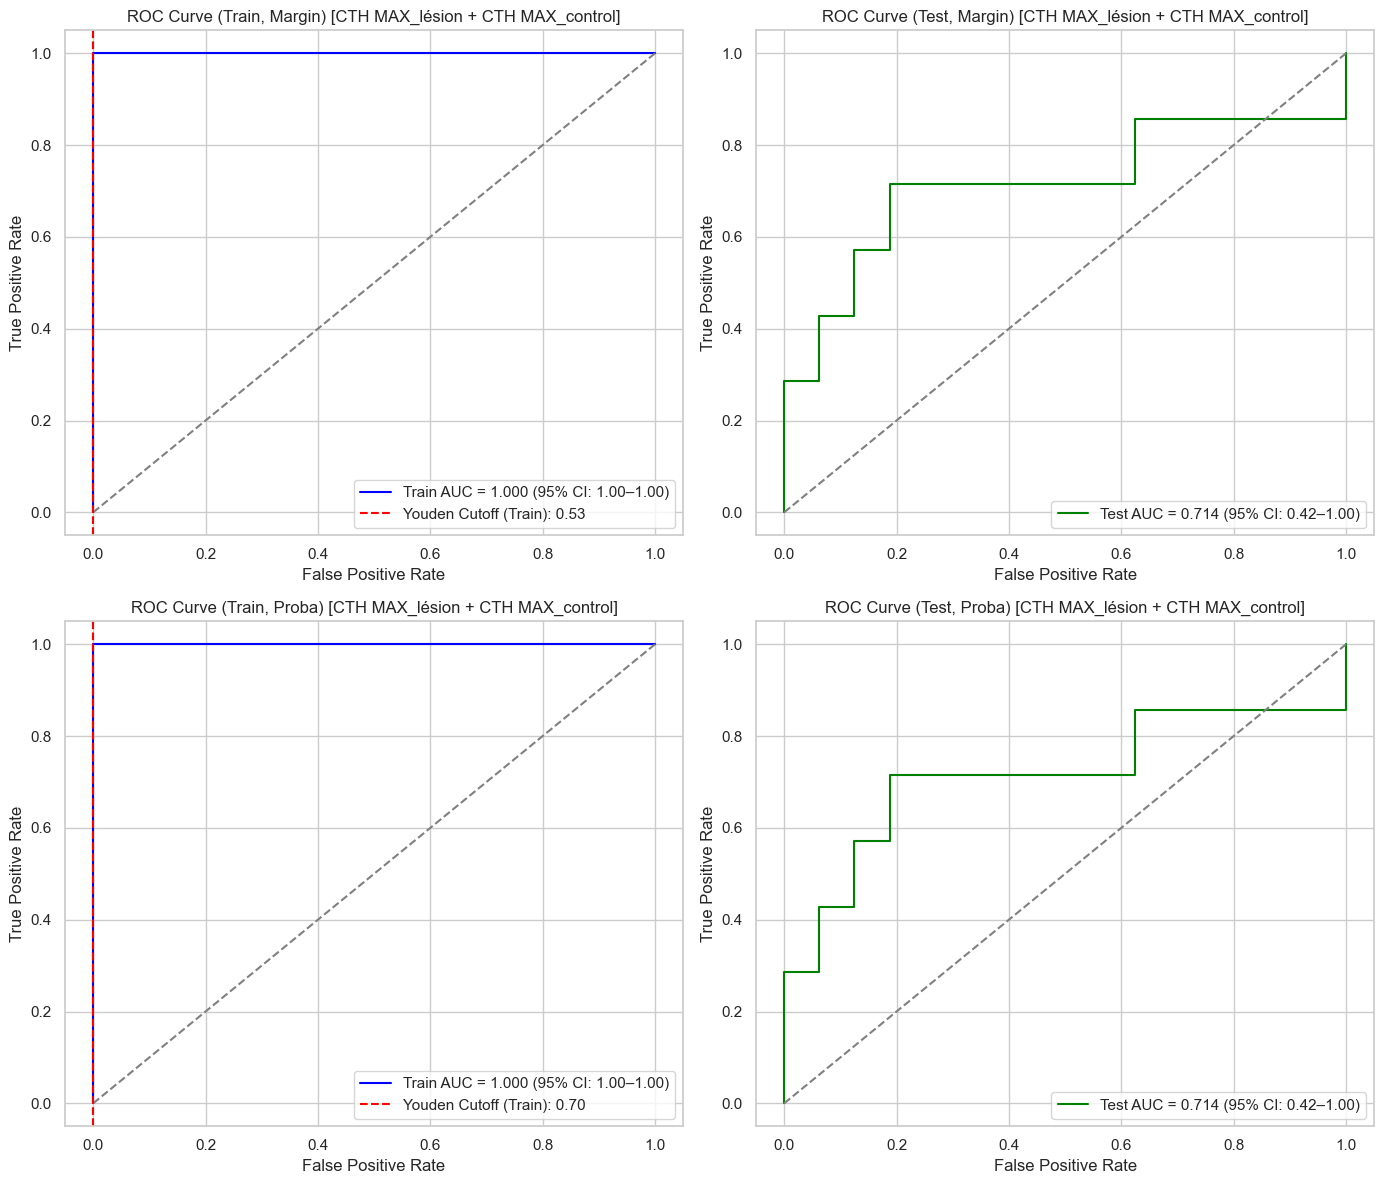

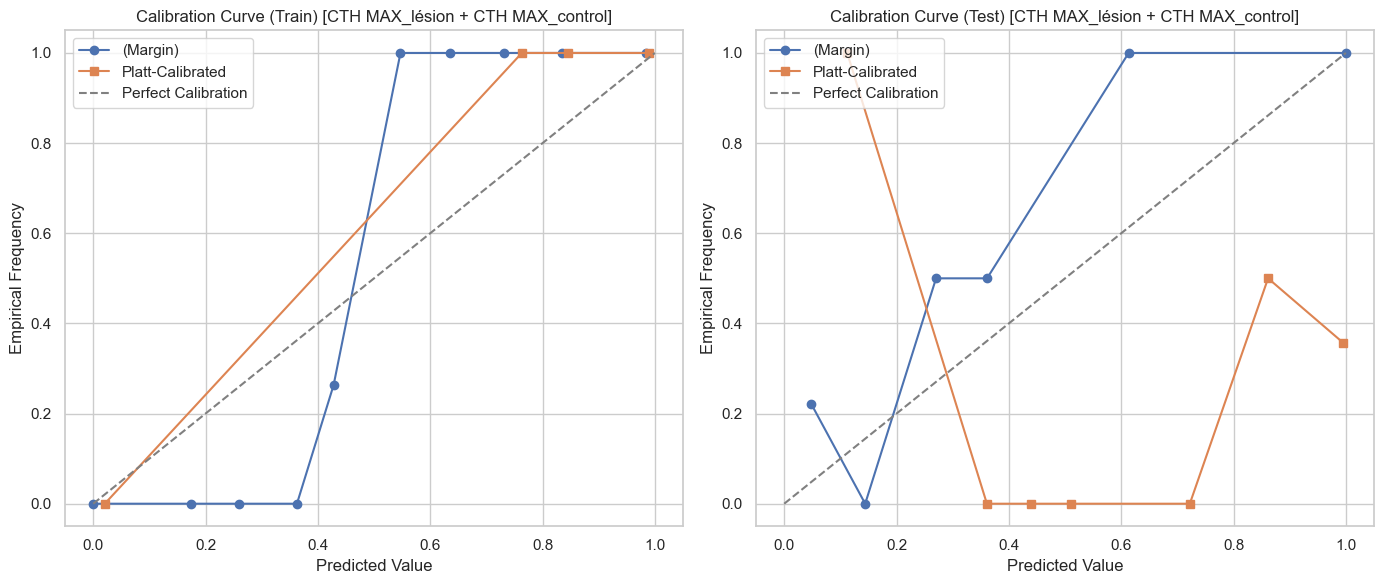

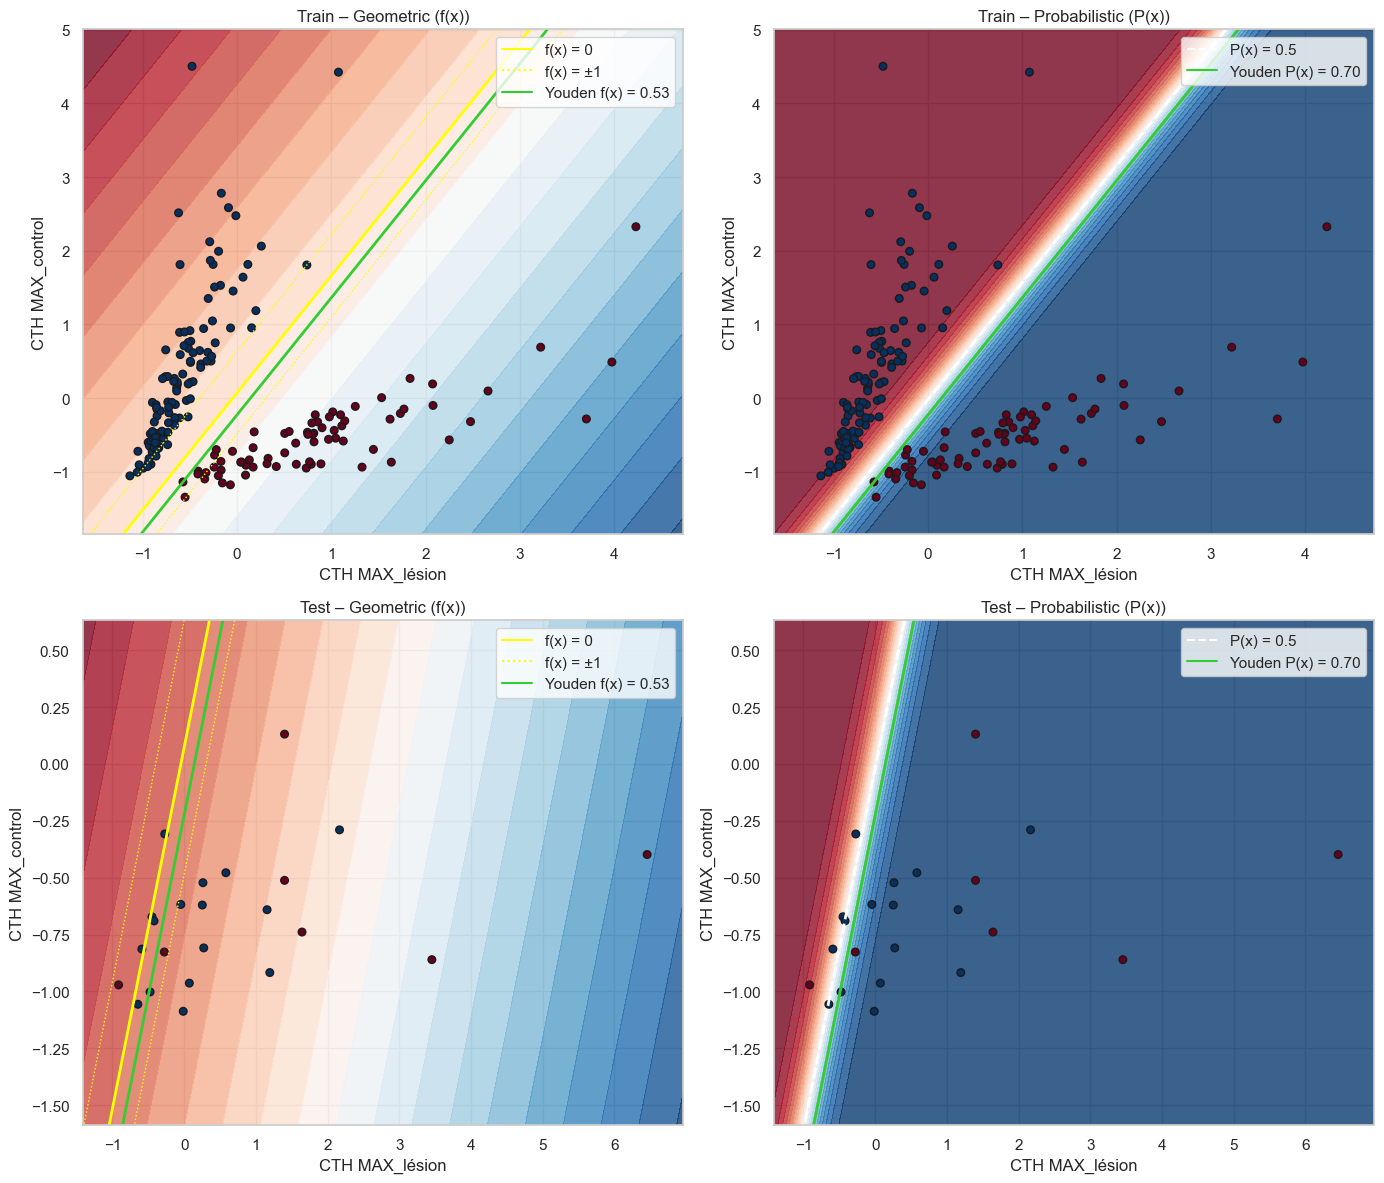

In [22]:
ub.evaluate_svm_bivariate_model(kernel="linear")

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
SVM (RBF) BIVARIATE: CTH MAX_lésion + CTH MAX_control
----------------------------------------------------------------------------------------------------
[Margin] Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Margin] Test  AUC : 0.321 (95% CI: 0.094 – 0.549)
Optimal Margin Cutoff (Youden): 0.475
----------------------------------------------------------------------------------------------------
[Proba]  Train AUC : 1.000 (95% CI: 1.000 – 1.000)
[Proba]  Test  AUC : 0.321 (95% CI: 0.094 – 0.549)
Optimal Proba  Cutoff (Youden): 0.873

▶ [CTH MAX_LÉSION + CTH MAX_CONTROL] TRAIN @ F(X) ≥ 0
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |    

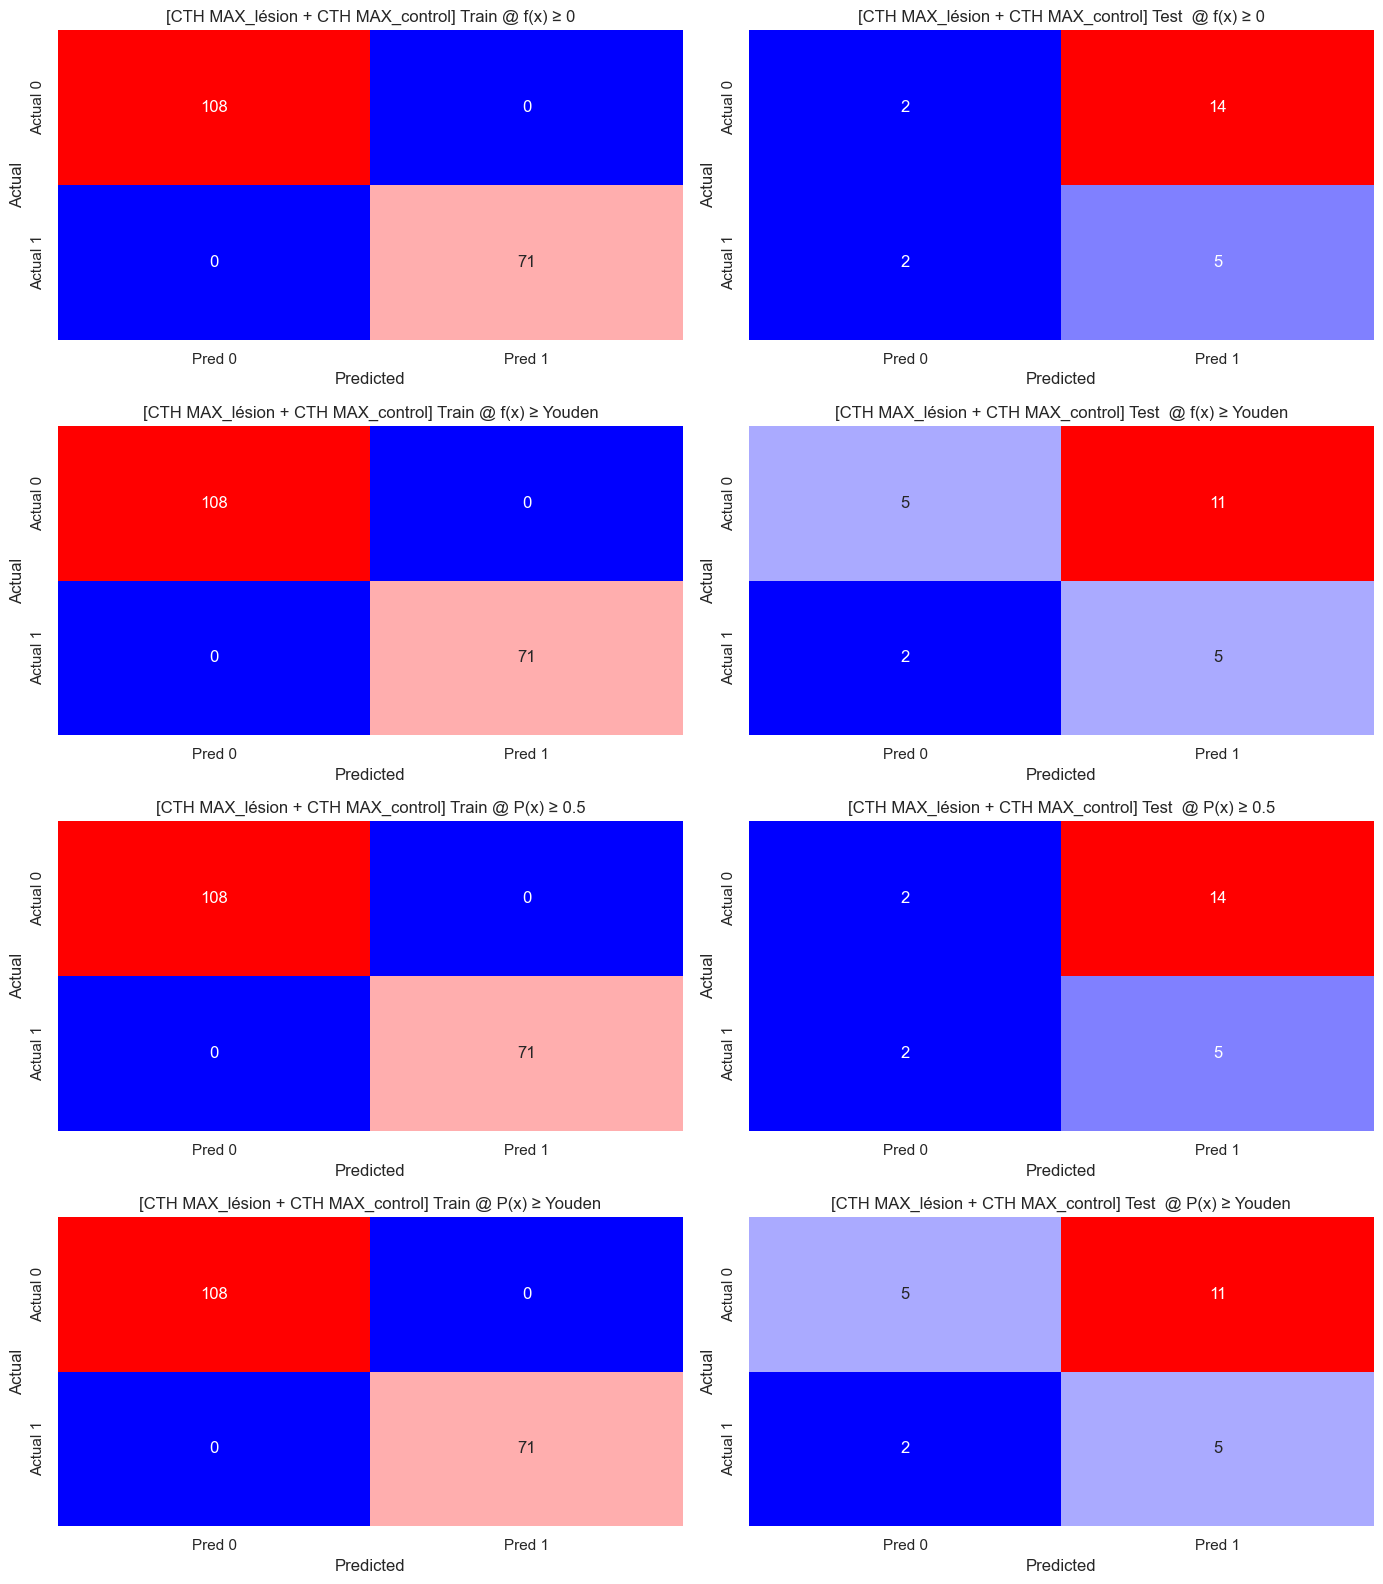

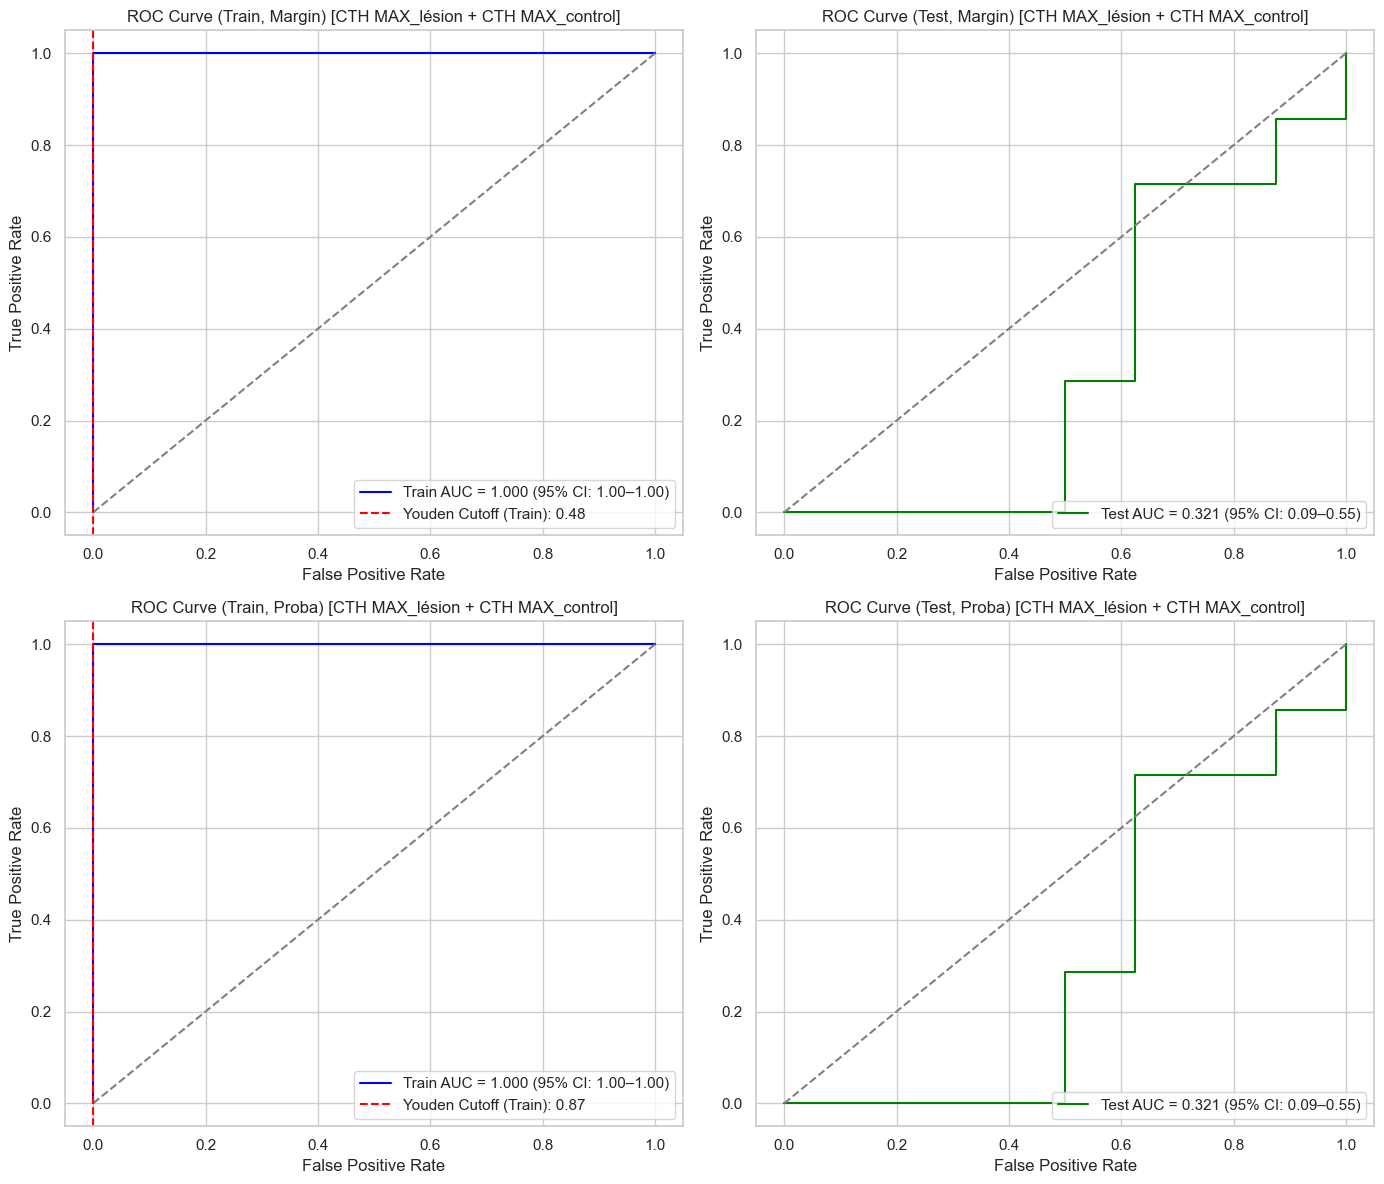

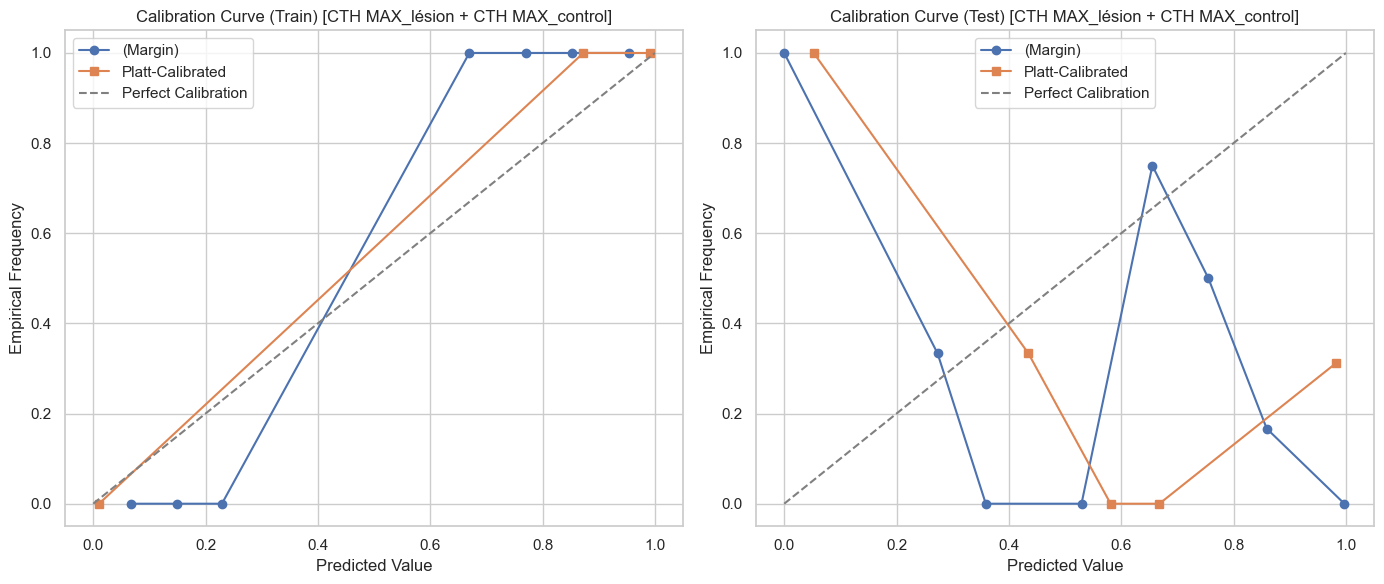

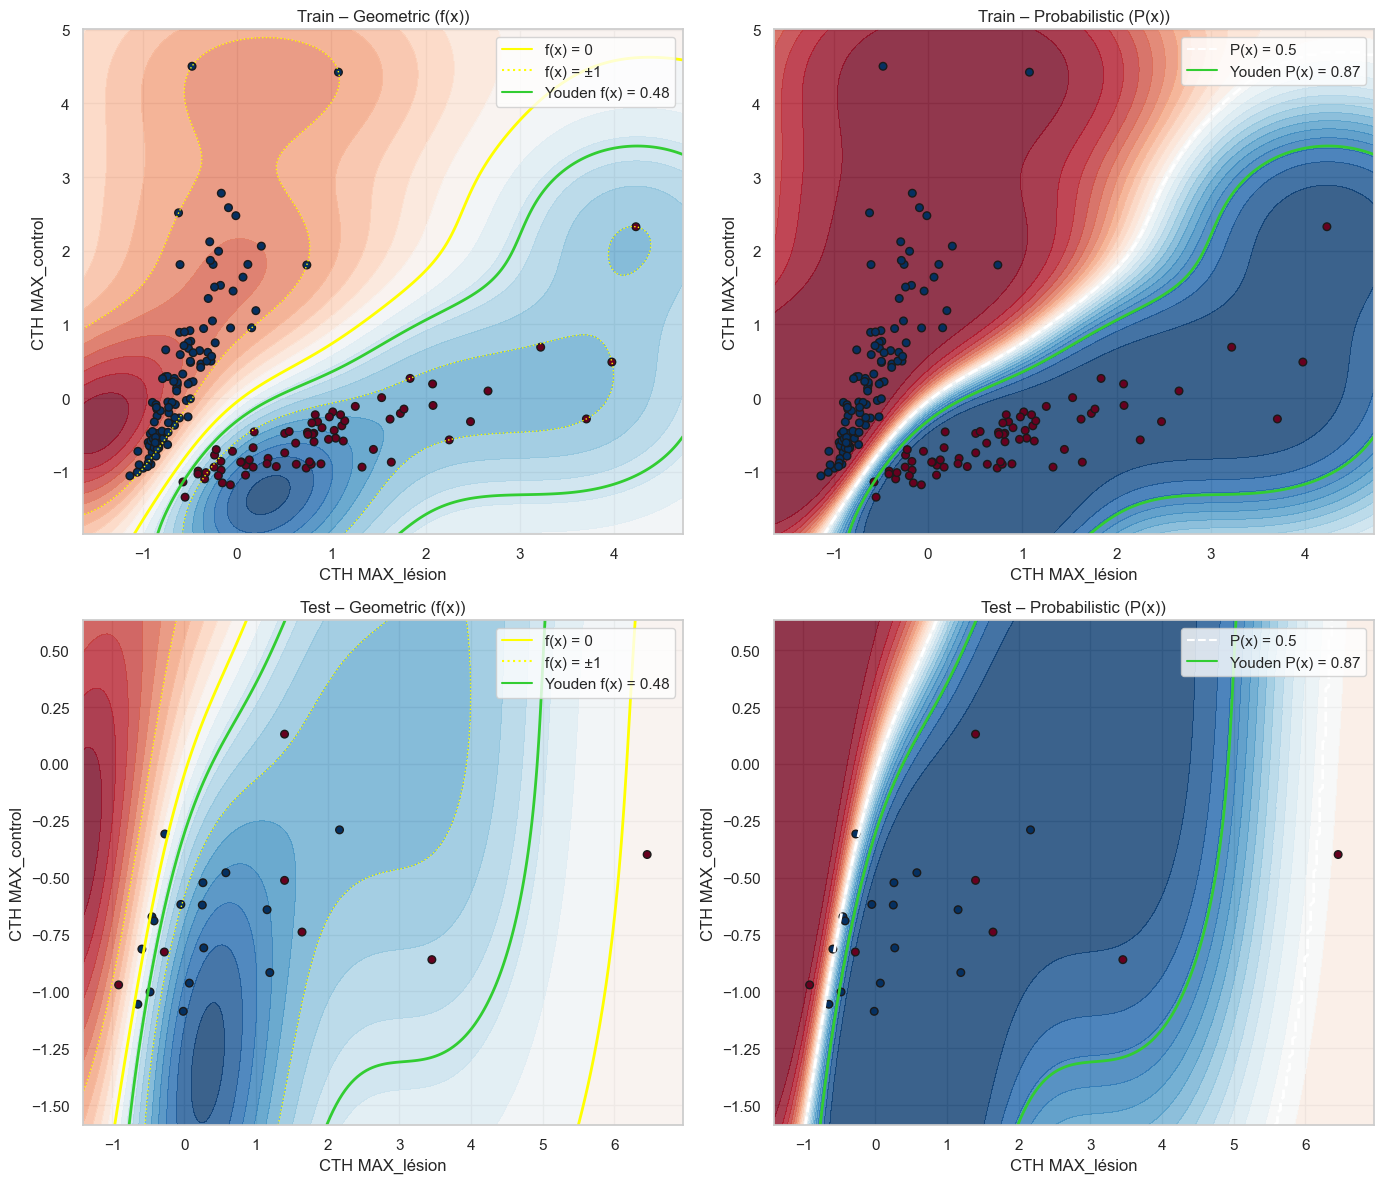

In [23]:
ub.evaluate_svm_bivariate_model(kernel="rbf")

## 6.  Decision Tree Modelling

Covariance of AUC is 0.0; defaulting to a small delta for CI computation.
DECISION TREE (max_depth=3, criterion=GINI): CTH MAX_lésion + CTH MAX_control + CTH MAX_ratio
----------------------------------------------------------------------------------------------------
AUC (Train): 1.000 (95% CI: 1.000 – 1.000)
AUC (Test) : 0.491 (95% CI: 0.328 – 0.654)
----------------------------------------------------------------------------------------------------

▶ [CTH MAX_LÉSION + CTH MAX_CONTROL + CTH MAX_RATIO] TRAIN
--------------------------------------------------
Metric               |  Value (%)
--------------------------------------------------
Accuracy             |     100.0
Recall (Sensitivity) |     100.0
Specificity          |     100.0
Precision            |     100.0
F1 Score             |     100.0

▶ [CTH MAX_LÉSION + CTH MAX_CONTROL + CTH MAX_RATIO] TEST
--------------------------------------------------
Metric               |  Value (%)
---------------------------------------

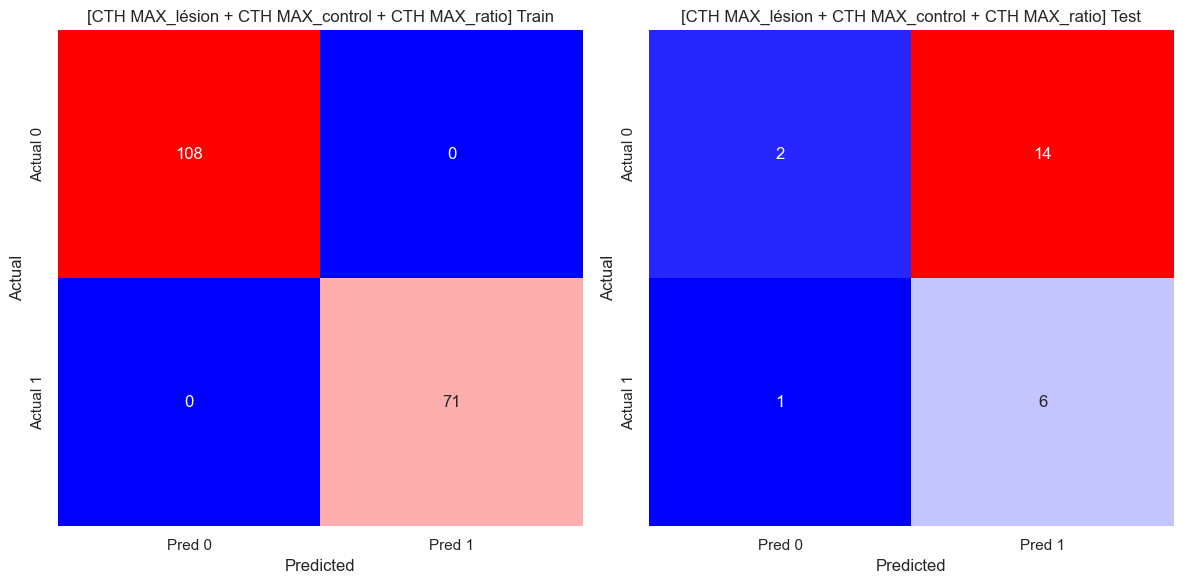

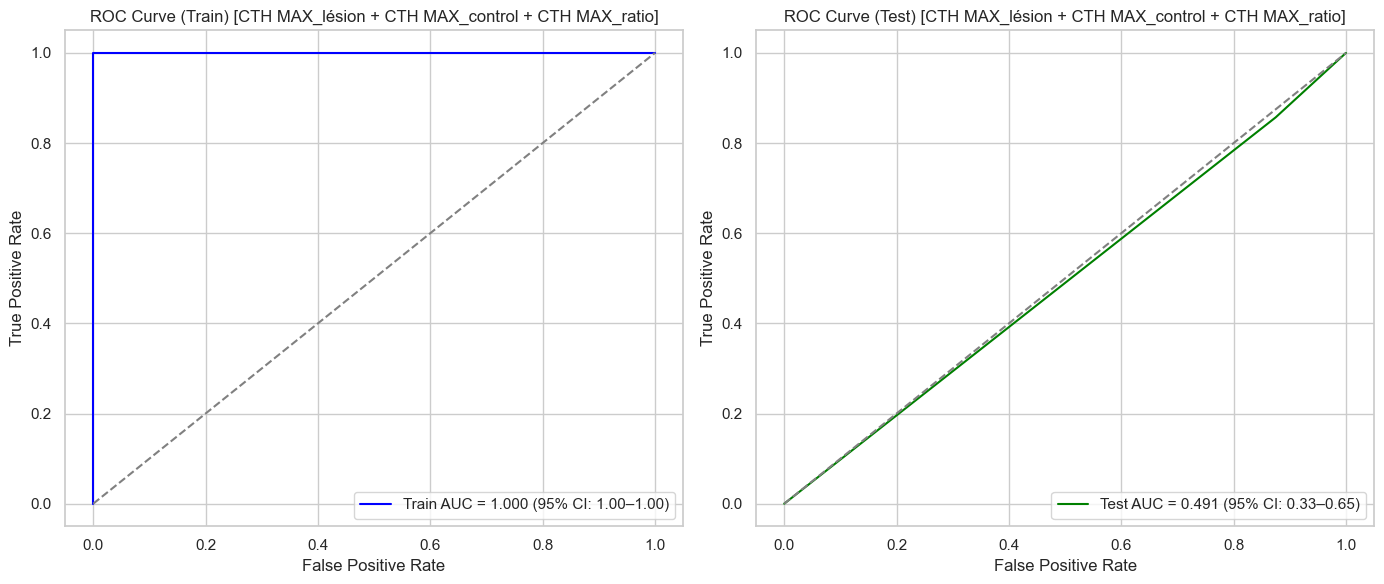

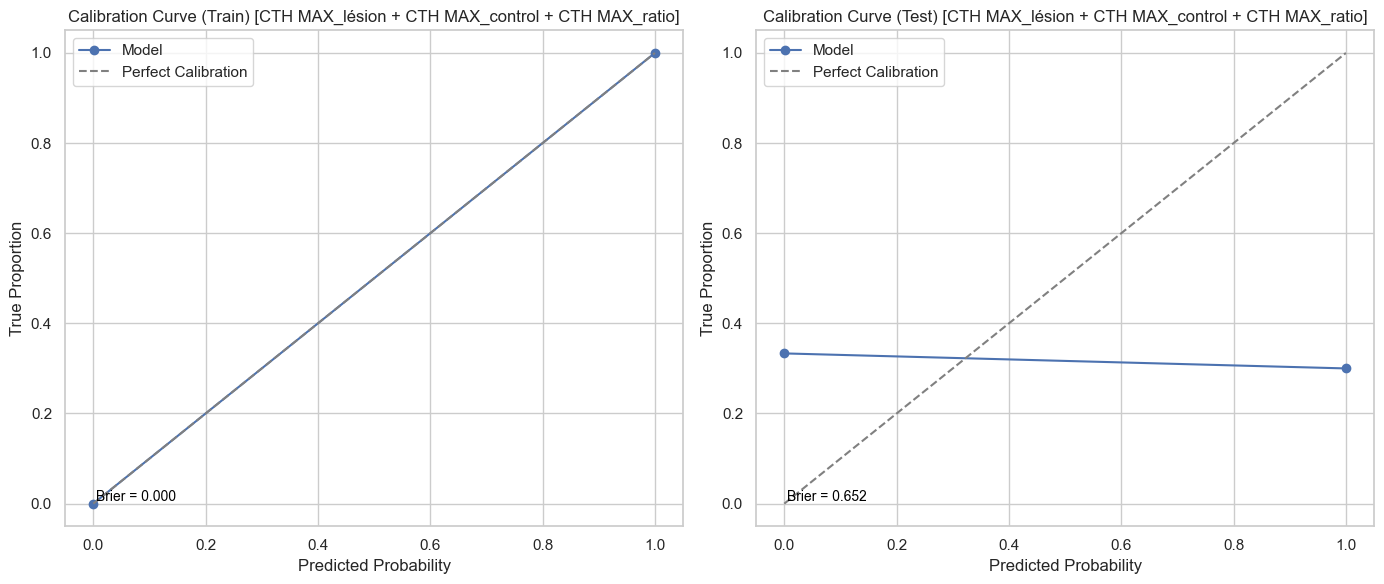

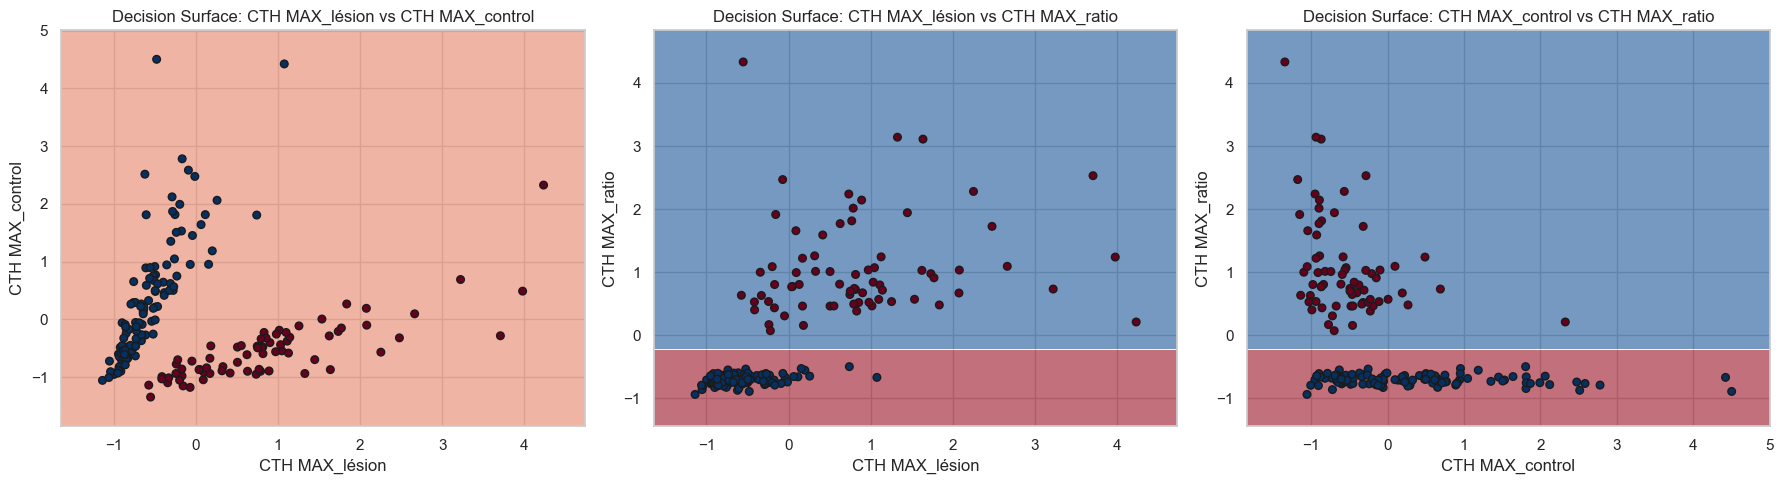

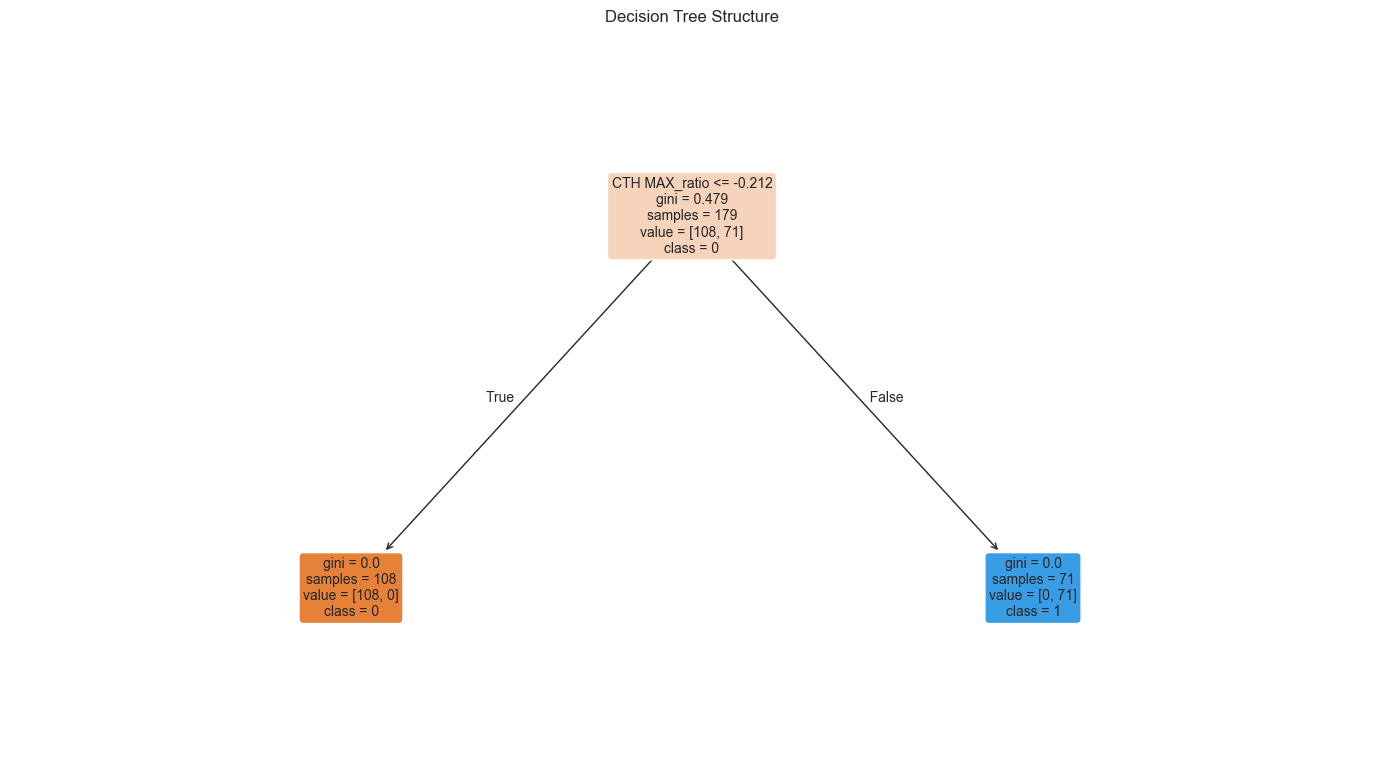


Tree Rules :
--------------------------------------------------------------------------------
|--- CTH MAX_ratio <= -0.21
|   |--- class: 0
|--- CTH MAX_ratio >  -0.21
|   |--- class: 1



In [24]:
ub.evaluate_tree_trivariate_model()